<a href="https://colab.research.google.com/github/import-cj/SentimentAnalysis_Malayalam/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow
!pip install transformers
!pip install tensorflow_hub
!pip install tensorflow_text
!pip install bert-for-tf2 --quiet
!pip install sentencepiece
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.8 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 596 kB 59.5 MB/s 
     |████████████████████████████████| 6.6 MB 41.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 7.1 MB/s 
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
     |████████████████████████████████| 1.6 MB 58.3 MB/s 
     |████████████████████████████████| 5.8 MB 50.9 MB/s 
     |████████████████████████████████| 438 kB 59.9 MB/s 
  Attempting uninstall: tensorflo

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9193176070746005412
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16118448128
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16416319926262923901
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [ ]:
import os
import numpy as np
import glob
import torch
import sys
import pandas as pd
import gc
from scipy.spatial import distance
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

#import tensorflow_datasets as tfds

In [ ]:
import transformers
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel, AutoTokenizer, AutoModel, AutoModelForMaskedLM
import tensorflow as tf
import tensorflow_hub as hub
from bert import bert_tokenization
from bert import tokenization
import tensorflow_text as text
from torch import cuda
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from tqdm import tqdm, trange

from pathlib import Path

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
    RemBertModel,
    RemBertTokenizer,
)

In [ ]:
#from sentence_transformers import SentenceTransformer
device = "cuda" if torch.cuda.is_available() else "cpu"  
torch.device(device)  
print("Current Device :", device)

Current Device : cuda


In [ ]:
# packages
import pandas as pd
from collections import Counter

import numpy as np
import sklearn
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
class model:
  def __init__(self,df,model_name):
    self.tokenizer=None
    self.model=None
    self.tokenized_padded_text=None
    self.attention_mask=None
    self.textip=None
    self.pooledOp=None
    self.input_dfs=None
    self.data_frame=df
    self.feature_df=None
    self.model_name=None
    self.InitModel(model_name)
  
  def reset(self,df):
    self.tokenized_padded_text=None
    self.attention_mask=None
    self.textip=None
    self.pooledOp=None
    self.input_dfs=None
    self.data_frame=df
    self.feature_df=None
    torch.cuda.empty_cache()
    gc.collect()

  def InitModel(self,model_name="ai4bharat/indic-bert") :
    from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if model_name == 'google/rembert':
      self.tokenizer = RemBertTokenizer.from_pretrained(model_name, model_max_length=512)
      self.model = RemBertModel.from_pretrained(model_name).to(device)
    if model_name == 'xlm-roberta-base':
      self.model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
      self.tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
    elif model_name == 'bert-base-multilingual-cased':
      self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',  model_max_length=512)
      self.model = BertModel.from_pretrained("bert-base-multilingual-cased").to(device)
    elif model_name == 'distilbert-base-uncased':
      model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')  
      self.tokenizer = tokenizer_class.from_pretrained(pretrained_weights,  model_max_length=512)
      self.model = model_class.from_pretrained(pretrained_weights).to(device)
    else:
      self.model = AutoModel.from_pretrained(model_name).to(device)
      self.tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
    self.model.eval()
    self.model_name=model_name
  
  def tokenize(self,column):
       torch.cuda.empty_cache()
       gc.collect()
       tokenized_text=column.apply((lambda x: self.tokenizer.encode(x, add_special_tokens=True, truncation=True)))
       max_len = 0
       k=0
       for i in tokenized_text.values:
        #if len(i) > 500:
        #  print(k,len(i), i)
        if len(i) > max_len:
         max_len = len(i)
        k+=1
       self.tokenized_padded_text = np.array([i + [0]*(max_len-len(i)) for i in tokenized_text.values])
       tokenized_text = None
       self.create_attention_mask()
       gc.collect()
       torch.cuda.empty_cache()

  def create_attention_mask(self):
      torch.cuda.empty_cache()
      gc.collect()
      self.attention_mask = np.where(self.tokenized_padded_text != 0, 1, 0)
      self.input_ids = torch.tensor(self.tokenized_padded_text).to(device)  
      self.attention_mask = torch.tensor(self.attention_mask).to(device)
      torch.cuda.empty_cache()
      gc.collect()

  def GetFeatures(self,input=None):
   torch.cuda.empty_cache()
   gc.collect()
   with torch.no_grad():
    last_hidden_states = self.model(self.input_ids, attention_mask=self.attention_mask)
   torch.cuda.empty_cache()
   self.features = last_hidden_states[0][:,0,:].cpu().numpy()
   self.features=pd.DataFrame(self.features)
   torch.cuda.empty_cache()
   gc.collect()
   return self.features

In [ ]:
class classifiers:

  def __init__(self,traindf,testdf, style):
    self.Createstaticsplit(traindf,testdf, style)

  def classify(self,svm=False,svm2=False,svm3=False,random_forest=False,xgboost=False,logistic_regression=False,maj=False)  :
      if svm==True:
        y=self.CreateSVMClassifier()
        self.y_svm1 = y
        #print('svm')
      if svm2==True:
        y=self.CreateSVMClassifier2()
        self.y_svm2 = y
        #print('svm2')
      if svm3==True:
        y=self.CreateSVMClassifier3()
        self.y_svm3 = y
        #print('svm3')
      if random_forest==True:
        y=self.RandomForestClassifier()
        self.y_rf = y
        #print('random_forest')
      if xgboost==True:
        y=self.XGBClassifier(3)
        self.y_xgboost = y
        #print('xgboost')
      if logistic_regression==True:
        y=self.LogisticRegression()
        self.y_lr = y
        #print('lr')
      if maj==True:
        y=self.MajorityVotingClassifier()
        self.y_lr = y
        #print('lr')
      return y

  def MajorityVotingClassifier(self):
        y_pred = list()
        for i in range(len(self.y_xgboost)):
            preds = list()
            preds.append(self.y_xgboost[i])
            preds.append(self.y_rf[i])
            preds.append(self.y_lr[i])
            preds.append(self.y_svm1[i])
            preds.append(self.y_svm2[i])
            preds.append(self.y_svm3[i])
            y_pred.append(max(set(preds), key=preds.count))
        return y_pred 

  def XGBClassifier(self,num_class=3):
     from xgboost import XGBClassifier
     classifier = XGBClassifier(n_estimators=500,learning_rate=1, max_depth=2,objective='multi:softmax',num_class=num_class)
     classifier.fit(self.train_features, self.train_labels)
     y_pred = classifier.predict(self.test_features)
     return y_pred

  def CreateSVMClassifier(self):
    from sklearn.svm import SVC
    classifier = SVC(kernel = 'poly',decision_function_shape='ovr', random_state = 0, C=1000)
    classifier.fit(self.train_features, self.train_labels)
  
    y_pred = classifier.predict(self.test_features)
    return y_pred

  def CreateSVMClassifier2(self):
    from sklearn.svm import SVC
    classifier = SVC(kernel = 'rbf',decision_function_shape='ovr', random_state = 0, C=1000)
    classifier.fit(self.train_features, self.train_labels)
  
    y_pred = classifier.predict(self.test_features)
    return y_pred

  def CreateSVMClassifier3(self):
    from sklearn.svm import SVC
    classifier = SVC(kernel = 'linear',decision_function_shape='ovr', random_state = 0, C=10)
    classifier.fit(self.train_features, self.train_labels)
  
    y_pred = classifier.predict(self.test_features)
    return y_pred

  def RandomForestClassifier(self):
     from sklearn.ensemble import RandomForestClassifier
     classifier = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
     classifier.fit(self.train_features, self.train_labels)

     y_pred = classifier.predict(self.test_features)
     return y_pred

  def Createstaticsplit(self,traindf, testdf,style):
   if style == 1:
    self.train_features = traindf.iloc[:, :-1]
    self.test_features = testdf.iloc[:, :-1]
   else:
    count_vec = None
    if style==2:
      count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)
    else:
      count_vec = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
    count_vec.fit(traindf['text'])
    self.train_features = count_vec.transform(traindf['text']) 
    self.test_features = count_vec.transform(testdf['text'])
   self.train_labels=traindf.sentiment
   self.test_labels=testdf.sentiment
  def annClassifier(self):
      import tensorflow as tf
      from sklearn.compose import ColumnTransformer
      from sklearn.preprocessing import OneHotEncoder
      ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
      feature_set = np.array(ct.fit_transform(self.features_set))
      train_features, test_features, train_labels, test_labels = train_test_split(feature_set, self.labels)

      ann = tf.keras.models.Sequential()
      ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
      ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
      ann.add(tf.keras.layers.Dense(units=1, activation='softmax'))
      ann.add(tf.keras.layers.Dense(units=1, activation='softmax'))
      ann.add(tf.keras.layers.Dense(units=1, activation='softmax'))
      ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
      ann.fit(train_features, train_labels, batch_size = 32, epochs = 200)

      y_pred = ann.predict(test_features)

      return accuracy_score(test_labels, y_pred),f1_score(test_labels, y_pred,average='macro')

  def LogisticRegression(self):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression 
    lr_clf = LogisticRegression(multi_class='multinomial', C= 5, max_iter=1001)
    lr_clf.fit(self.train_features, self.train_labels) 

    y_pred=lr_clf.predict(self.test_features)
    return y_pred

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"  
torch.device(device)  
print("Current Device :", device)

Current Device : cuda


In [ ]:
def ReadData():
 cols=["text","clean-text","sentiment"]
 nm = "youtube_comments_cleaned_dataset.csv"
 df = pd.read_csv(nm, encoding='utf-8', usecols=cols)
 nm = "newsdataset_cleaned.csv"
 ndf = pd.read_csv(nm, encoding='utf-8', usecols=cols)
 ndf = ndf[ndf['sentiment'] == "neutral"]
 return pd.concat([df,ndf],ignore_index=True)

def ExtractFeatures(dataset,labels,model_name):
  model_pipeline=model(dataset,model_name)
  #model_pipeline.tokenize(dataset.text)
  feature_df_mbert=model_pipeline.GetFeatures(dataset.text)
  feature_df_mbert['label']=labels
  return feature_df_mbert 

def SaveAsCsv(dataframe,modelname):
    filename='CD_'+str(modelname)+'.csv'
    dataframe.to_csv(filename,index=False)

def testtrainsplit(df,frac=0.20):
  from sklearn.model_selection import train_test_split
  trainx = [] 
  testx = []
  for i in [0,1,2]:
     tdf = df[df['sentiment'] == i]
     t1, t2 = train_test_split(tdf, test_size=frac, random_state=0)
     num=len(tdf)
     trainx.append(t1)
     testx.append(t2)
  return pd.concat(trainx),pd.concat(testx)

def run_experiment(style=None, model_name=None, stem=False, stopwords=False, subset=100):
  torch.cuda.empty_cache()
  gc.collect()
  dataset=ReadData()
  dataset['sentiment'] = dataset.sentiment.map({'neutral':0, 'negative':1, 'positive':2})
  mystopwords = ['ഇത്തരം', 'ഒരു', 'ഈ',  'ആണ്', 'വളരെ', 'ഞാൻ', 'തന്നെ', 'ആ', 'വീഡിയോ',  'എന്റെ', 'നമ്മുടെ', 'എല്ലാ', 'അത്', 'എന്ന', 'കൊണ്ട്', 'ഉള്ള', 'ഇത്',  'എല്ലാം', 'എനിക്ക്', 'ഓരോ',  'പിന്നെ',  'ഒക്കെ',  'നിങ്ങൾ', 'വേണ്ടി', 'മാത്രം', 'നിങ്ങളുടെ', 'നിന്നും', 'കൂടെ', 'ഏറ്റവും', 'ഇങ്ങനെ', 'അവരുടെ',  'കാരണം', 'ഇല്ല', 'കൂടുതൽ', '-', 'എല്ലാവർക്കും', 'അവർ', 'പോലും', 'വീണ്ടും', 'എന്നു', 'ചെയ്യാൻ', 'അവിടെ', 'സ്വന്തം', 'അതിന്റെ', 'ഇവിടെ', 'അങ്ങനെ',  'എല്ലാവരും',  'ഞങ്ങൾ',  'നമ്മൾ', 'നമുക്ക്',  'പക്ഷെ', 'നീ',  'പക്ഷേ', 'എന്നെ',  'എന്നാൽ',  'ആരും', 'അതിൽ',  'അല്ല', 'ശേഷം',  'എന്ത്', 'താങ്കൾ', 'എങ്ങനെ', 'അതാണ്',  'നിങ്ങൾക്ക്', ')', 'അവർക്ക്',  'ഏത്',  'മറ്റു', 'അവരെ',
'നല്ല', 'ഉണ്ട്','എന്ന്', 'പോലെ', 'ആയി', 'കണ്ടു', 'ഒന്നും', 'നിന്ന്', 'വരെ', 'ചെയ്തു', 'വന്നു', 'ആയിരുന്നു', 'അടുത്ത', 'ചെയ്യുന്ന', 'പല', 'വേറെ', 'ചില', 'മതി', 'ഒരിക്കലും', 'കുറിച്ച്', 'പറഞ്ഞ', 'വന്ന', 'താങ്കളുടെ', 'ചേട്ടൻ', 'ചേട്ടാ', 'ചെയ്ത', 'നൽകി', 'കണ്ട്', 'എൻറെ', 'വെച്ച്', 'യും', 'നിങ്ങളെ', 'പറഞ്ഞത്', 'മാത്രമേ', 'അവൻ', 'എന്തെങ്കിലും', 'എന്നത്', 'എന്താണ്', 'കഴിഞ്ഞു', 'അറിയാം', 'അതു', 'മാത്രമാണ്', 'അതിനെ', 'ചെയ്ത്', 'ഇവർ', 'സ്വയം', 'മുൻപ്', 'ഉള്ളത്', 'പേര്'
'ഇപ്പോൾ', 'ഇനി', 'ഇനിയും', 'ഇനി' , 'ഇപ്പോൾ' , 'എങ്കിൽ', 'അപ്പോൾ', 'അല്ലെങ്കിൽ', 'ഇതിൽ', 'ഇതൊക്കെ', 'ഇത്രയും', 'ഇതിന്റെ', 'ഞങ്ങളുടെ', 'ഇതാണ്' , 'പിന്നീട്']
  mystopwords = set(mystopwords)
  if stem:
    dataset['text'] = dataset['clean-text']
  if stopwords:
    def stopfilter(row):
      text = row['text']
      ntxt = filter(lambda x: x not in mystopwords, text.split())
      return " ".join(list(ntxt))
    dataset['text'] = dataset.apply(stopfilter, axis=1)
  if style == 1:
    name = model_name
    dflist = []
    model_pipeline=model(None, model_name)
    for k,g in dataset.groupby(np.arange(len(dataset))//subset):
      model_pipeline.reset(g)
      model_pipeline.tokenize(g.text)
      dflist.append(model_pipeline.GetFeatures(g.text))
    dataframe = pd.concat(dflist,ignore_index=True)
    dataframe['sentiment'] = dataset.sentiment
  elif style < 4:
    name = "Count vectorizer"
    if style==3:
      name = "Tfidf vectorizer"
    dataframe = dataset
  elif style == 4:
    name = "Sentence Transformer "+model_name
    smodel = SentenceTransformer(model_name)
    features = smodel.encode(list(dataset.text))
    dataframe = pd.DataFrame(features)
    dataframe['sentiment'] = dataset.sentiment
    style = 1
  else:
    return
  header="\nEXPERIMENT | feature-extract: "+name+" | stopwords : "+str(stopwords)+ " | stemmer:"+str(stem)
  print(header)
  underline="-"*(len(header))
  underline+= "--\n\n"
  print(underline)
  classify(dataframe, style)
  torch.cuda.empty_cache()
  gc.collect()

In [ ]:
def classify(df, style):
      t1,t2=testtrainsplit(df)
      classifier_class=classifiers(t1,t2,style)
      test_labels=t2.sentiment
   
      def doClassifier(name, **kwargs):
        nonlocal test_labels
        y_pred=classifier_class.classify(**kwargs)
        print("\t\t\t"+name)
        print(classification_report(test_labels, y_pred, labels=[0,1,2]))
   
      doClassifier(name = "Logistic Regression", logistic_regression=True)
      #doClassifier(name = "SVM poly kernel",svm=True)
      doClassifier(name = "SVM rbf kernel",svm2=True)
      doClassifier(name = "SVM linear kernel",svm3=True)
      doClassifier(name = "Random Forest",random_forest=True)
      doClassifier(name = "XGBoost",xgboost=True)
      #doClassifier(name = "Majority Voting classifier of all classifiers", maj=True)
   

In [ ]:
#1/0#run_experiment(style=2, model_name=None, stem=True, stopwords=True, subset=100)

In [ ]:
#run_experiment(style=1, model_name='ai4bharat/indic-bert', stem=False, stopwords=False, subset=400)

In [ ]:
#run_experiment(style=4, model_name='aditeyabaral/sentencetransformer-indic-bert', stem=False, stopwords=False, subset=400)
ReadData()['sentiment'].value_counts()

positive    2394
negative    2391
neutral     1921
Name: sentiment, dtype: int64

In [ ]:
import copy

# load all experiments and download all models from huggingface
wordvec = ['ai4bharat/indic-bert',  'setu4993/LaBSE', 'google/muril-large-cased', 'ai4bharat/IndicBART', 'bert-base-multilingual-cased', 'google/rembert']
sentencevec = ['aditeyabaral/sentencetransformer-indic-bert', 'sentence-transformers/LaBSE']

experiments = []

for i in range(2,4):
  exp = {
    'style' : i,
    'model_name' : None,
    'stem' : False,
    'stopwords' : False,
    'subset' : None
  }
  experiments.append(exp)
  texp = copy.deepcopy(exp)
  texp['stem'] = True
  experiments.append(texp)
  texp = copy.deepcopy(exp)
  texp['stopwords'] = True
  experiments.append(texp)

for s in sentencevec:
  exp = {
    'style' : 4,
    'model_name' : s,
    'stem' : False,
    'stopwords' : False,
    'subset' : None
  }
  SentenceTransformer(s)
  experiments.append(exp)
  texp = copy.deepcopy(exp)
  texp['stem'] = True
  experiments.append(texp)
  texp = copy.deepcopy(exp)
  texp['stopwords'] = True
  experiments.append(texp)

for w in wordvec:
  exp = {
    'style' : 1,
    'model_name' : w,
    'stem' : False,
    'stopwords' : False,
    'subset' : 100
  }
  model(None, w)
  experiments.append(exp)
  texp = copy.deepcopy(exp)
  texp['stem'] = True
  experiments.append(texp)
  texp = copy.deepcopy(exp)
  texp['stopwords'] = True
  experiments.append(texp)

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/823 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/123 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.88M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/470 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.dense.weight', 'sop_classifier.classifier.bias', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at google/muril-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at ai4bharat/IndicBART were not used when initializing MBartModel: ['final_logits_bias', 'lm_head.weight']
- This IS expected if you are initializing MBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# run all
for exp in experiments:
  run_experiment(**exp)



EXPERIMENT | feature-extract: Count vectorizer | stopwords : False | stemmer:False
-------------------------------------------------------------------------------------


			Logistic Regression
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       385
           1       0.68      0.72      0.70       479
           2       0.77      0.72      0.75       479

    accuracy                           0.70      1343
   macro avg       0.70      0.70      0.70      1343
weighted avg       0.70      0.70      0.70      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       385
           1       0.64      0.65      0.65       479
           2       0.77      0.67      0.72       479

    accuracy                           0.66      1343
   macro avg       0.67      0.66      0.66      1343
weighted avg       0.67      0.66      0.67      1343

			SVM linear kernel
    

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.dense.weight', 'sop_classifier.classifier.bias', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: ai4bharat/indic-bert | stopwords : False | stemmer:False
-----------------------------------------------------------------------------------------


			Logistic Regression
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       385
           1       0.59      0.72      0.65       479
           2       0.62      0.51      0.56       479

    accuracy                           0.62      1343
   macro avg       0.63      0.62      0.62      1343
weighted avg       0.62      0.62      0.62      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       385
           1       0.62      0.70      0.66       479
           2       0.67      0.62      0.64       479

    accuracy                           0.66      1343
   macro avg       0.67      0.66      0.66      1343
weighted avg       0.66      0.66      0.66      1343

			SVM linear ker

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.dense.weight', 'sop_classifier.classifier.bias', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: ai4bharat/indic-bert | stopwords : False | stemmer:True
----------------------------------------------------------------------------------------


			Logistic Regression
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       385
           1       0.59      0.74      0.65       479
           2       0.66      0.53      0.58       479

    accuracy                           0.63      1343
   macro avg       0.64      0.63      0.63      1343
weighted avg       0.64      0.63      0.63      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       385
           1       0.65      0.71      0.68       479
           2       0.66      0.66      0.66       479

    accuracy                           0.67      1343
   macro avg       0.68      0.67      0.67      1343
weighted avg       0.67      0.67      0.67      1343

			SVM linear kerne

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.dense.weight', 'sop_classifier.classifier.bias', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: ai4bharat/indic-bert | stopwords : True | stemmer:False
----------------------------------------------------------------------------------------


			Logistic Regression
              precision    recall  f1-score   support

           0       0.67      0.62      0.65       385
           1       0.59      0.71      0.64       479
           2       0.63      0.52      0.57       479

    accuracy                           0.62      1343
   macro avg       0.63      0.62      0.62      1343
weighted avg       0.62      0.62      0.62      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       385
           1       0.65      0.70      0.67       479
           2       0.66      0.66      0.66       479

    accuracy                           0.67      1343
   macro avg       0.68      0.67      0.67      1343
weighted avg       0.67      0.67      0.67      1343

			SVM linear kerne

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       385
           1       0.73      0.78      0.75       479
           2       0.77      0.76      0.76       479

    accuracy                           0.75      1343
   macro avg       0.75      0.74      0.75      1343
weighted avg       0.75      0.75      0.75      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       385
           1       0.75      0.79      0.77       479
           2       0.82      0.79      0.80       479

    accuracy                           0.77      1343
   macro avg       0.77      0.77      0.77      1343
weighted avg       0.77      0.77      0.77      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       385
           1       0.72      0.71      0.72       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       385
           1       0.73      0.77      0.75       479
           2       0.78      0.75      0.76       479

    accuracy                           0.75      1343
   macro avg       0.75      0.75      0.75      1343
weighted avg       0.75      0.75      0.75      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       385
           1       0.72      0.78      0.75       479
           2       0.80      0.76      0.78       479

    accuracy                           0.75      1343
   macro avg       0.75      0.75      0.75      1343
weighted avg       0.75      0.75      0.75      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       385
           1       0.71      0.71      0.71       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       385
           1       0.73      0.75      0.74       479
           2       0.76      0.75      0.76       479

    accuracy                           0.73      1343
   macro avg       0.73      0.73      0.73      1343
weighted avg       0.73      0.73      0.73      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       385
           1       0.73      0.78      0.75       479
           2       0.79      0.75      0.77       479

    accuracy                           0.75      1343
   macro avg       0.75      0.75      0.75      1343
weighted avg       0.75      0.75      0.75      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.64      0.69      0.67       385
           1       0.72      0.71      0.71       479
           2 

Some weights of the model checkpoint at google/muril-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: google/muril-large-cased | stopwords : False | stemmer:False
---------------------------------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       385
           1       0.75      0.77      0.76       479
           2       0.76      0.74      0.75       479

    accuracy                           0.74      1343
   macro avg       0.73      0.73      0.73      1343
weighted avg       0.74      0.74      0.74      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       385
           1       0.75      0.78      0.77       479
           2       0.80      0.78      0.79       479

    accuracy                           0.76      1343
   macro avg       0.76      0.76      0.76      1343
weighted avg       0.76      0.76      0.76      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.61      0.74      0.66       385
           1       0.72      0.67      0.70       479
           2 

Some weights of the model checkpoint at google/muril-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: google/muril-large-cased | stopwords : False | stemmer:True
--------------------------------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       385
           1       0.72      0.73      0.73       479
           2       0.75      0.74      0.74       479

    accuracy                           0.72      1343
   macro avg       0.72      0.72      0.72      1343
weighted avg       0.72      0.72      0.72      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       385
           1       0.77      0.77      0.77       479
           2       0.79      0.79      0.79       479

    accuracy                           0.77      1343
   macro avg       0.76      0.76      0.76      1343
weighted avg       0.77      0.77      0.77      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       385
           1       0.74      0.67      0.70       479
           2 

Some weights of the model checkpoint at google/muril-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: google/muril-large-cased | stopwords : True | stemmer:False
--------------------------------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       385
           1       0.71      0.73      0.72       479
           2       0.75      0.71      0.73       479

    accuracy                           0.71      1343
   macro avg       0.71      0.71      0.71      1343
weighted avg       0.71      0.71      0.71      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       385
           1       0.75      0.78      0.76       479
           2       0.80      0.78      0.79       479

    accuracy                           0.76      1343
   macro avg       0.76      0.75      0.75      1343
weighted avg       0.76      0.76      0.76      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       385
           1       0.72      0.67      0.70       479
           2 

Some weights of the model checkpoint at ai4bharat/IndicBART were not used when initializing MBartModel: ['final_logits_bias', 'lm_head.weight']
- This IS expected if you are initializing MBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: ai4bharat/IndicBART | stopwords : False | stemmer:False
----------------------------------------------------------------------------------------


			Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.65      0.72       385
           1       0.54      0.68      0.60       479
           2       0.59      0.53      0.56       479

    accuracy                           0.62      1343
   macro avg       0.64      0.62      0.63      1343
weighted avg       0.63      0.62      0.62      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       385
           1       0.55      0.62      0.58       479
           2       0.59      0.56      0.57       479

    accuracy                           0.60      1343
   macro avg       0.62      0.61      0.61      1343
weighted avg       0.61      0.60      0.60      1343

			SVM linear kerne

Some weights of the model checkpoint at ai4bharat/IndicBART were not used when initializing MBartModel: ['final_logits_bias', 'lm_head.weight']
- This IS expected if you are initializing MBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: ai4bharat/IndicBART | stopwords : False | stemmer:True
---------------------------------------------------------------------------------------


			Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.62      0.67       385
           1       0.57      0.68      0.62       479
           2       0.60      0.56      0.58       479

    accuracy                           0.62      1343
   macro avg       0.63      0.62      0.62      1343
weighted avg       0.63      0.62      0.62      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       385
           1       0.57      0.59      0.58       479
           2       0.57      0.57      0.57       479

    accuracy                           0.59      1343
   macro avg       0.60      0.59      0.59      1343
weighted avg       0.59      0.59      0.59      1343

			SVM linear kernel


Some weights of the model checkpoint at ai4bharat/IndicBART were not used when initializing MBartModel: ['final_logits_bias', 'lm_head.weight']
- This IS expected if you are initializing MBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: ai4bharat/IndicBART | stopwords : True | stemmer:False
---------------------------------------------------------------------------------------


			Logistic Regression
              precision    recall  f1-score   support

           0       0.76      0.64      0.70       385
           1       0.57      0.68      0.62       479
           2       0.59      0.56      0.57       479

    accuracy                           0.62      1343
   macro avg       0.64      0.62      0.63      1343
weighted avg       0.63      0.62      0.63      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.68      0.63      0.66       385
           1       0.53      0.56      0.55       479
           2       0.56      0.57      0.56       479

    accuracy                           0.58      1343
   macro avg       0.59      0.59      0.59      1343
weighted avg       0.59      0.58      0.58      1343

			SVM linear kernel


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: bert-base-multilingual-cased | stopwords : False | stemmer:False
-------------------------------------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       385
           1       0.64      0.68      0.66       479
           2       0.67      0.67      0.67       479

    accuracy                           0.68      1343
   macro avg       0.68      0.68      0.68      1343
weighted avg       0.68      0.68      0.68      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       385
           1       0.60      0.62      0.61       479
           2       0.65      0.61      0.63       479

    accuracy                           0.63      1343
   macro avg       0.63      0.63      0.63      1343
weighted avg       0.63      0.63      0.63      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       385
           1       0.63      0.63      0.63       479
           2 

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: bert-base-multilingual-cased | stopwords : False | stemmer:True
------------------------------------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       385
           1       0.62      0.65      0.64       479
           2       0.63      0.62      0.63       479

    accuracy                           0.64      1343
   macro avg       0.64      0.64      0.64      1343
weighted avg       0.64      0.64      0.64      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       385
           1       0.60      0.59      0.59       479
           2       0.64      0.61      0.62       479

    accuracy                           0.62      1343
   macro avg       0.62      0.62      0.62      1343
weighted avg       0.62      0.62      0.62      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       385
           1       0.62      0.64      0.63       479
           2 

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



EXPERIMENT | feature-extract: bert-base-multilingual-cased | stopwords : True | stemmer:False
------------------------------------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       385
           1       0.63      0.66      0.65       479
           2       0.64      0.64      0.64       479

    accuracy                           0.65      1343
   macro avg       0.65      0.65      0.65      1343
weighted avg       0.65      0.65      0.65      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       385
           1       0.66      0.63      0.64       479
           2       0.64      0.63      0.63       479

    accuracy                           0.64      1343
   macro avg       0.63      0.64      0.63      1343
weighted avg       0.64      0.64      0.64      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       385
           1       0.62      0.64      0.63       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       385
           1       0.75      0.78      0.76       479
           2       0.78      0.78      0.78       479

    accuracy                           0.76      1343
   macro avg       0.75      0.75      0.75      1343
weighted avg       0.75      0.76      0.75      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       385
           1       0.73      0.75      0.74       479
           2       0.74      0.73      0.74       479

    accuracy                           0.72      1343
   macro avg       0.72      0.72      0.72      1343
weighted avg       0.72      0.72      0.72      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       385
           1       0.73      0.74      0.73       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       385
           1       0.70      0.75      0.73       479
           2       0.75      0.73      0.74       479

    accuracy                           0.73      1343
   macro avg       0.73      0.73      0.73      1343
weighted avg       0.73      0.73      0.73      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       385
           1       0.70      0.75      0.72       479
           2       0.75      0.69      0.72       479

    accuracy                           0.71      1343
   macro avg       0.71      0.71      0.71      1343
weighted avg       0.71      0.71      0.71      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       385
           1       0.70      0.74      0.72       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       385
           1       0.72      0.75      0.73       479
           2       0.74      0.74      0.74       479

    accuracy                           0.73      1343
   macro avg       0.73      0.72      0.72      1343
weighted avg       0.73      0.73      0.73      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       385
           1       0.71      0.75      0.73       479
           2       0.75      0.72      0.74       479

    accuracy                           0.71      1343
   macro avg       0.71      0.71      0.71      1343
weighted avg       0.71      0.71      0.71      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       385
           1       0.71      0.70      0.70       479
           2 

In [ ]:
from google.colab import files
import glob
import shutil
from google.colab import drive
drive.mount('/content/drive')

try:
  for f in  glob.glob('/content/drive/MyDrive/dataset_*.gzip'):
    shutil.copy(f, ".")
except:
  pass
#!ls /content/drive/MyDrive/*cleaned*

try:
  shutil.copy("/content/drive/MyDrive/newsdataset_cleaned.txt", ".")
  shutil.copy("/content/drive/MyDrive/youtube_comments_cleaned_dataset.txt", ".")
except:
  pass

KeyboardInterrupt: ignored

In [ ]:
def getOffensiveColumn():
 cols=["sentiment", "offensive"]
 nm = "youtube_comments_cleaned_dataset.txt"
 df = pd.read_csv(nm, encoding='utf-8', usecols=cols)
 nm = "newsdataset_cleaned.txt"
 ndf = pd.read_csv(nm, encoding='utf-8', usecols=cols)
 ndf = ndf[ndf['sentiment'] == "neutral"]
 ndf['offensive'] = 0
 return pd.concat([df,ndf],ignore_index=True)

df=getOffensiveColumn()
df[df['offensive']==1]


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [ ]:
#!nvcc --version command 
!pip install tsnecuda
#!conda uninstall torch
!conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
#model_name="/content/dataset_word_muril_stem.gzip"
#dataset = pd.read_parquet(model_name)
#type(dataset.iloc[:, :-1])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Solving environment: | / - \ | / - \ | / - \ | / - \ WARNING conda.core.solve:_add_specs(649): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
| / - \ | / - \ | / done

# All requested packages already installed.



In [ ]:
import torch
import copy
from tsnecuda import TSNE

def classify2(df, style):
      tsne_result = df.iloc[:, :-1].to_numpy()
      tsne_result = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(tsne_result)
      torch.cuda.empty_cache()
      gc.collect()
      df.insert(loc=0, column='tsne0', value=tsne_result[:,0])
      df.insert(loc=1, column='tsne1', value=tsne_result[:,1])
      tsne_result=None
      torch.cuda.empty_cache()
      gc.collect()
      t1,t2=testtrainsplit(df)
      classifier_class=classifiers(t1,t2,style)
      test_labels=t2.sentiment
   
      def doClassifier(name, **kwargs):
        nonlocal test_labels
        y_pred=classifier_class.classify(**kwargs)
        print("\t\t\t"+name)
        print(classification_report(test_labels, y_pred, labels=[0,1,2]))
   
      doClassifier(name = "Logistic Regression", logistic_regression=True)
      #doClassifier(name = "SVM poly kernel",svm=True)
      doClassifier(name = "SVM rbf kernel",svm2=True)
      doClassifier(name = "SVM linear kernel",svm3=True)
      doClassifier(name = "Random Forest",random_forest=True)
      doClassifier(name = "XGBoost",xgboost=True)
      #doClassifier(name = "Majority Voting classifier of all classifiers", maj=True)
   

def run_exp(model_name=None):
  torch.cuda.empty_cache()
  gc.collect()
  dataframe = pd.read_parquet(model_name)
  style = 1
  header="\nEXPERIMENT | data : "+model_name.split("/")[2]
  print(header)
  underline="-"*(len(header))
  underline+= "--\n\n"
  print(underline)
  classify2(dataframe, style)
  torch.cuda.empty_cache()
  gc.collect()

ModuleNotFoundError: ignored

In [ ]:

for f in  glob.glob('/content/dataset_*.gzip'):
  run_exp(f)


EXPERIMENT | data : dataset_word_LaBSE_stop.gzip
---------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       385
           1       0.74      0.76      0.75       479
           2       0.77      0.75      0.76       479

    accuracy                           0.74      1343
   macro avg       0.74      0.73      0.74      1343
weighted avg       0.74      0.74      0.74      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       385
           1       0.75      0.78      0.77       479
           2       0.80      0.78      0.79       479

    accuracy                           0.76      1343
   macro avg       0.76      0.76      0.76      1343
weighted avg       0.76      0.76      0.76      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       385
           1       0.71      0.71      0.71       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       385
           1       0.75      0.80      0.77       479
           2       0.80      0.78      0.79       479

    accuracy                           0.77      1343
   macro avg       0.77      0.77      0.77      1343
weighted avg       0.77      0.77      0.77      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       385
           1       0.71      0.74      0.72       479
           2       0.77      0.72      0.75       479

    accuracy                           0.72      1343
   macro avg       0.72      0.72      0.72      1343
weighted avg       0.73      0.72      0.72      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       385
           1       0.73      0.81      0.77       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.72      0.76       385
           1       0.75      0.82      0.79       479
           2       0.81      0.79      0.80       479

    accuracy                           0.78      1343
   macro avg       0.78      0.78      0.78      1343
weighted avg       0.78      0.78      0.78      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       385
           1       0.73      0.75      0.74       479
           2       0.79      0.77      0.78       479

    accuracy                           0.75      1343
   macro avg       0.75      0.74      0.75      1343
weighted avg       0.75      0.75      0.75      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       385
           1       0.74      0.82      0.77       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       385
           1       0.75      0.76      0.75       479
           2       0.75      0.75      0.75       479

    accuracy                           0.73      1343
   macro avg       0.73      0.73      0.73      1343
weighted avg       0.73      0.73      0.73      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       385
           1       0.74      0.76      0.75       479
           2       0.78      0.75      0.77       479

    accuracy                           0.75      1343
   macro avg       0.75      0.75      0.75      1343
weighted avg       0.75      0.75      0.75      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.60      0.74      0.66       385
           1       0.73      0.68      0.70       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       385
           1       0.73      0.77      0.75       479
           2       0.78      0.75      0.76       479

    accuracy                           0.75      1343
   macro avg       0.75      0.75      0.75      1343
weighted avg       0.75      0.75      0.75      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       385
           1       0.70      0.77      0.73       479
           2       0.80      0.75      0.77       479

    accuracy                           0.74      1343
   macro avg       0.74      0.73      0.73      1343
weighted avg       0.74      0.74      0.74      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       385
           1       0.71      0.70      0.70       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       385
           1       0.70      0.75      0.72       479
           2       0.76      0.73      0.74       479

    accuracy                           0.73      1343
   macro avg       0.73      0.73      0.73      1343
weighted avg       0.73      0.73      0.73      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       385
           1       0.69      0.73      0.71       479
           2       0.73      0.69      0.71       479

    accuracy                           0.70      1343
   macro avg       0.70      0.70      0.70      1343
weighted avg       0.70      0.70      0.70      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       385
           1       0.70      0.74      0.72       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       385
           1       0.73      0.77      0.75       479
           2       0.77      0.75      0.76       479

    accuracy                           0.74      1343
   macro avg       0.74      0.74      0.74      1343
weighted avg       0.74      0.74      0.74      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       385
           1       0.75      0.76      0.75       479
           2       0.79      0.76      0.78       479

    accuracy                           0.75      1343
   macro avg       0.75      0.75      0.75      1343
weighted avg       0.75      0.75      0.75      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       385
           1       0.74      0.73      0.73       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       385
           1       0.75      0.77      0.76       479
           2       0.79      0.78      0.78       479

    accuracy                           0.76      1343
   macro avg       0.76      0.76      0.76      1343
weighted avg       0.76      0.76      0.76      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       385
           1       0.71      0.75      0.73       479
           2       0.74      0.73      0.73       479

    accuracy                           0.71      1343
   macro avg       0.71      0.71      0.71      1343
weighted avg       0.71      0.71      0.71      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       385
           1       0.72      0.73      0.73       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       385
           1       0.72      0.73      0.72       479
           2       0.74      0.72      0.73       479

    accuracy                           0.71      1343
   macro avg       0.71      0.71      0.71      1343
weighted avg       0.71      0.71      0.71      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       385
           1       0.74      0.76      0.75       479
           2       0.79      0.77      0.78       479

    accuracy                           0.75      1343
   macro avg       0.75      0.75      0.75      1343
weighted avg       0.75      0.75      0.75      1343



In [ ]:
flag=True
for f in  glob.glob('/content/dataset_*.gzip'):
  if flag and f=="/content/dataset_word_muril_stop.gzip":
    flag=False
  if flag:
    continue
  run_exp(f)


EXPERIMENT | data : dataset_word_muril_stop.gzip
---------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       385
           1       0.72      0.73      0.72       479
           2       0.74      0.73      0.73       479

    accuracy                           0.71      1343
   macro avg       0.71      0.71      0.71      1343
weighted avg       0.71      0.71      0.71      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       385
           1       0.75      0.76      0.75       479
           2       0.78      0.78      0.78       479

    accuracy                           0.75      1343
   macro avg       0.75      0.74      0.74      1343
weighted avg       0.75      0.75      0.75      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.56      0.68      0.62       385
           1       0.72      0.67      0.69       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       385
           1       0.73      0.82      0.77       479
           2       0.80      0.76      0.78       479

    accuracy                           0.77      1343
   macro avg       0.77      0.76      0.76      1343
weighted avg       0.77      0.77      0.77      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       385
           1       0.70      0.73      0.71       479
           2       0.77      0.73      0.75       479

    accuracy                           0.72      1343
   macro avg       0.72      0.72      0.72      1343
weighted avg       0.72      0.72      0.72      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       385
           1       0.74      0.82      0.78       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       385
           1       0.72      0.73      0.72       479
           2       0.75      0.73      0.74       479

    accuracy                           0.72      1343
   macro avg       0.72      0.72      0.72      1343
weighted avg       0.72      0.72      0.72      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       385
           1       0.78      0.76      0.77       479
           2       0.79      0.79      0.79       479

    accuracy                           0.77      1343
   macro avg       0.76      0.76      0.76      1343
weighted avg       0.77      0.77      0.77      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       385
           1       0.73      0.68      0.71       479
           2 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


			Logistic Regression
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       385
           1       0.72      0.74      0.73       479
           2       0.74      0.74      0.74       479

    accuracy                           0.73      1343
   macro avg       0.72      0.72      0.72      1343
weighted avg       0.73      0.73      0.73      1343

			SVM rbf kernel
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       385
           1       0.72      0.73      0.72       479
           2       0.75      0.76      0.75       479

    accuracy                           0.72      1343
   macro avg       0.72      0.72      0.72      1343
weighted avg       0.72      0.72      0.72      1343

			SVM linear kernel
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       385
           1       0.70      0.70      0.70       479
           2 

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
import numpy as np
from xgboost import XGBClassifier

def getClassifier(traindf, testdf, cname, params):
  X_train = traindf.iloc[:, :-1]
  X_test = testdf.iloc[:, :-1]
  y_train = traindf.sentiment
  y_test = testdf.sentiment
  class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y=y_train)
  class_weights = dict(zip(np.unique(y_train), class_weights))
  if cname =="SVC": 
    return SVC(probability=True,class_weight=class_weights,**params)
  if cname =="LR": 
    return LogisticRegression(multi_class='multinomial',max_iter=1001,class_weight=class_weights, n_jobs=-1,**params)
  if cname =="RF":    
    return RandomForestClassifier(class_weight=class_weights, n_jobs=-1,**params)
  if cname =="XGB":    
    return XGBClassifier(n_jobs=-1,**params)
  return None

p = {'max_depth': 21, 'learning_rate': 0.501956198584188, 'gamma': 0.5594101354848587, 'reg_lambda': 4.3100873161896, 'scale_pos_weight': 0.15277043788751965, 'n_estimators': 88, 'min_child_weight': 2.599012704295227, 'subsample': 0.7712922105242364, 'colsample_bytree': 0.9240655929783459, 'colsample_bylevel': 0.6001338661583275, 'reg_alpha': 2.51915811238953}
p = {'max_depth': 10, 'learning_rate': 1.402752049052525, 'gamma': 1.045988672020692, 'reg_lambda': 9.090254962792395, 'scale_pos_weight': 1.5249821840200823, 'n_estimators': 342, 'min_child_weight': 2.966808880527082, 'subsample': 0.9039473648541585, 'colsample_bytree': 0.889572538785252, 'colsample_bylevel': 0.7688059035157913, 'reg_alpha': 2.7635865136642446}
dataframe = pd.read_parquet("/content/dataset_word_muril_stem.gzip")
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf.iloc[:, :-1]
X_test = testdf.iloc[:, :-1]
y_train = traindf.sentiment
y_test = testdf.sentiment
classifier = getClassifier(traindf, testdf, "XGB", p)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.69      0.64      0.67       385
           1       0.69      0.73      0.71       479
           2       0.75      0.75      0.75       479

    accuracy                           0.71      1343
   macro avg       0.71      0.71      0.71      1343
weighted avg       0.71      0.71      0.71      1343



In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
import numpy as np
from xgboost import XGBClassifier

def getClassifier(traindf, testdf, cname, params):
  X_train = traindf.iloc[:, :-1]
  X_test = testdf.iloc[:, :-1]
  y_train = traindf.sentiment
  y_test = testdf.sentiment
  class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y=y_train)
  class_weights = dict(zip(np.unique(y_train), class_weights))
  if cname =="SVC": 
    return SVC(probability=True,class_weight=class_weights,**params)
  if cname =="LR": 
    return LogisticRegression(multi_class='multinomial',max_iter=1001,class_weight=class_weights, n_jobs=-1,**params)
  if cname =="RF":    
    return RandomForestClassifier(class_weight=class_weights, n_jobs=-1,**params)
  if cname =="XGB":    
    return XGBClassifier(n_jobs=-1,**params)
  return None

p = {'max_depth': 21, 'learning_rate': 0.501956198584188, 'gamma': 0.5594101354848587, 'reg_lambda': 4.3100873161896, 'scale_pos_weight': 0.15277043788751965, 'n_estimators': 88, 'min_child_weight': 2.599012704295227, 'subsample': 0.7712922105242364, 'colsample_bytree': 0.9240655929783459, 'colsample_bylevel': 0.6001338661583275, 'reg_alpha': 2.51915811238953}
p = {'max_depth': 10, 'learning_rate': 1.402752049052525, 'gamma': 1.045988672020692, 'reg_lambda': 9.090254962792395, 'scale_pos_weight': 1.5249821840200823, 'n_estimators': 342, 'min_child_weight': 2.966808880527082, 'subsample': 0.9039473648541585, 'colsample_bytree': 0.889572538785252, 'colsample_bylevel': 0.7688059035157913, 'reg_alpha': 2.7635865136642446}
dataframe = pd.read_parquet("dataset_word_muril_stem.gzip")
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf.iloc[:, :-1]
X_test = testdf.iloc[:, :-1]
y_train = traindf.sentiment
y_test = testdf.sentiment
#classifier = getClassifier(traindf, testdf, "XGB", p)
classifier = XGBClassifier(n_estimators=500,learning_rate=1, max_depth=2,objective='multi:softmax',num_class=3)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       385
           1       0.77      0.82      0.79       479
           2       0.80      0.81      0.80       479

    accuracy                           0.79      1343
   macro avg       0.79      0.78      0.78      1343
weighted avg       0.79      0.79      0.79      1343



In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
import numpy as np
from xgboost import XGBClassifier

def getClassifier(traindf, testdf, cname, params):
  X_train = traindf.iloc[:, :-1]
  X_test = testdf.iloc[:, :-1]
  y_train = traindf.sentiment
  y_test = testdf.sentiment
  class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y=y_train)
  class_weights = dict(zip(np.unique(y_train), class_weights))
  if cname =="SVC": 
    return SVC(probability=True,class_weight=class_weights,**params)
  if cname =="LR": 
    return LogisticRegression(multi_class='multinomial',max_iter=1001,class_weight=class_weights, n_jobs=-1,**params)
  if cname =="RF":    
    return RandomForestClassifier(class_weight=class_weights, n_jobs=-1,**params)
  if cname =="XGB":    
    return XGBClassifier(n_jobs=-1,**params,tree_method='gpu_hist',objective='multi:softmax')
  return None

p = {'max_depth': 21, 'learning_rate': 0.501956198584188, 'gamma': 0.5594101354848587, 'reg_lambda': 4.3100873161896, 'scale_pos_weight': 0.15277043788751965, 'n_estimators': 88, 'min_child_weight': 2.599012704295227, 'subsample': 0.7712922105242364, 'colsample_bytree': 0.9240655929783459, 'colsample_bylevel': 0.6001338661583275, 'reg_alpha': 2.51915811238953}
p = {'max_depth': 10, 'learning_rate': 1.402752049052525, 'gamma': 1.045988672020692, 'reg_lambda': 9.090254962792395, 'scale_pos_weight': 1.5249821840200823, 'n_estimators': 342, 'min_child_weight': 2.966808880527082, 'subsample': 0.9039473648541585, 'colsample_bytree': 0.889572538785252, 'colsample_bylevel': 0.7688059035157913, 'reg_alpha': 2.7635865136642446}
dataframe = pd.read_parquet("dataset_word_muril_stem.gzip")
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf.iloc[:, :-1]
X_test = testdf.iloc[:, :-1]
y_train = traindf.sentiment
y_test = testdf.sentiment
#classifier = getClassifier(traindf, testdf, "XGB", p)
classifier = XGBClassifier(n_estimators=500,learning_rate=1, max_depth=2,objective='multi:softmax',num_class=3,tree_method='gpu_hist')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0,1,2]))

y_pred = classifier.predict(X_train)
print(classification_report(y_train, y_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       577
           1       0.75      0.81      0.78       718
           2       0.79      0.80      0.80       719

    accuracy                           0.77      2014
   macro avg       0.78      0.77      0.77      2014
weighted avg       0.78      0.77      0.77      2014

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1344
           1       1.00      1.00      1.00      1673
           2       1.00      1.00      1.00      1675

    accuracy                           1.00      4692
   macro avg       1.00      1.00      1.00      4692
weighted avg       1.00      1.00      1.00      4692



In [ ]:
'''
import pickle
with open('xgbm.pkl', 'wb') as f:
    pickle.dump(classifier, f)

# and later you can load it
with open('xgbm.pkl', 'rb') as f:
    clf = pickle.load(f)
'''
classifier.save_model('xgb.json')

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
import numpy as np
from xgboost import XGBClassifier

def getClassifier(traindf, testdf, cname, params):
  X_train = traindf.iloc[:, :-1]
  X_test = testdf.iloc[:, :-1]
  y_train = traindf.sentiment
  y_test = testdf.sentiment
  class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y=y_train)
  class_weights = dict(zip(np.unique(y_train), class_weights))
  if cname =="SVC": 
    return SVC(probability=True,class_weight=class_weights,**params)
  if cname =="LR": 
    return LogisticRegression(multi_class='multinomial',max_iter=1001,class_weight=class_weights, n_jobs=-1,**params)
  if cname =="RF":    
    return RandomForestClassifier(class_weight=class_weights, n_jobs=-1,**params)
  if cname =="XGB":    
    return XGBClassifier(n_jobs=-1,**params)
  return None

p1 = {'max_depth': 21, 'learning_rate': 0.501956198584188, 'gamma': 0.5594101354848587, 'reg_lambda': 4.3100873161896, 'scale_pos_weight': 0.15277043788751965, 'n_estimators': 88, 'min_child_weight': 2.599012704295227, 'subsample': 0.7712922105242364, 'colsample_bytree': 0.9240655929783459, 'colsample_bylevel': 0.6001338661583275, 'reg_alpha': 2.51915811238953}
p2 = {'max_depth': 10, 'learning_rate': 1.402752049052525, 'gamma': 1.045988672020692, 'reg_lambda': 9.090254962792395, 'scale_pos_weight': 1.5249821840200823, 'n_estimators': 342, 'min_child_weight': 2.966808880527082, 'subsample': 0.9039473648541585, 'colsample_bytree': 0.889572538785252, 'colsample_bylevel': 0.7688059035157913, 'reg_alpha': 2.7635865136642446}
dataframe = pd.read_parquet("/content/dataset_word_muril_stem.gzip")
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf.iloc[:, :-1]
X_test = testdf.iloc[:, :-1]
y_train = traindf.sentiment
y_test = testdf.sentiment
#classifier = getClassifier(traindf, testdf, "XGB", p)
classifier1 = XGBClassifier(**p1,objective='multi:softmax',num_class=3)
classifier1.fit(X_train, y_train)
y_pred = classifier1.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0,1,2]))

classifier2 = XGBClassifier(**p2,objective='multi:softmax',num_class=3)
classifier2.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.74      0.68      0.71       385
           1       0.74      0.78      0.76       479
           2       0.76      0.77      0.76       479

    accuracy                           0.75      1343
   macro avg       0.75      0.74      0.74      1343
weighted avg       0.75      0.75      0.75      1343



NameError: ignored

In [ ]:
y_pred = classifier2.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       385
           1       0.71      0.76      0.73       479
           2       0.73      0.73      0.73       479

    accuracy                           0.72      1343
   macro avg       0.72      0.72      0.72      1343
weighted avg       0.72      0.72      0.72      1343



(6706, 2)


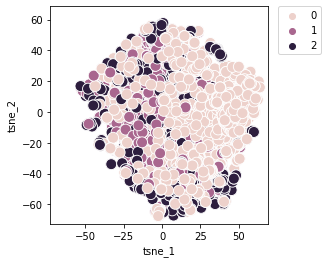

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from tsnecuda import TSNE
import matplotlib.pyplot as plt

df = pd.read_parquet("/content/dataset_word_muril_none.gzip") 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne_result = df.iloc[:, :-1].to_numpy()
tsne_result = TSNE(n_components=n_components, perplexity=5, learning_rate=62).fit_transform(tsne_result)
print(tsne_result.shape)
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': df.sentiment.to_numpy()})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

(6706, 2)


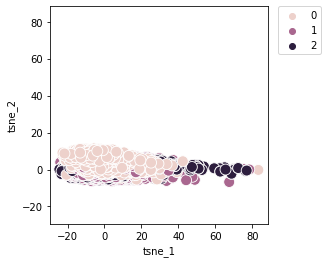

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
#from tsnecuda import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import glob



df = pd.read_parquet("/content/dataset_word_muril_none.gzip") 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne_result = df.iloc[:, :-1].to_numpy()
#tsne_result = TSNE(n_components=n_components, perplexity=5, learning_rate=62).fit_transform(tsne_result)
tsne_result = PCA(n_components=2).fit_transform(tsne_result)
print(tsne_result.shape)
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': df.sentiment.to_numpy()})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [ ]:
from tsnecuda import TSNE
import glob
import pandas as pd
import torch
plist = []
def getOffensiveColumn():
 cols=["sentiment", "offensive"]
 nm = "youtube_comments_cleaned_dataset.txt"
 df = pd.read_csv(nm, encoding='utf-8', usecols=cols)
 nm = "newsdataset_cleaned.txt"
 ndf = pd.read_csv(nm, encoding='utf-8', usecols=cols)
 ndf = ndf[ndf['sentiment'] == "neutral"]
 ndf['offensive'] = 0
 return pd.concat([df,ndf],ignore_index=True)

dfo=getOffensiveColumn()
dfo['sentiment'] = dfo.sentiment.map({'neutral':0, 'negative':1, 'positive':2})
for f in  glob.glob('/content/dataset_*muril*.gzip'):
      df = pd.read_parquet(f)
      tsne_result = df.iloc[:, :-1].to_numpy()
      tsne_result = TSNE(n_components=2, perplexity=5, learning_rate=62).fit_transform(tsne_result)
      df = pd.DataFrame({'off':dfo.offensive.to_numpy(), 'tsne0': tsne_result[:,0], 'tsne1': tsne_result[:,1], 'sentiment': df.sentiment.to_numpy()})
      #print(df.head())
      tsne_result=None
      torch.cuda.empty_cache()
      gc.collect()
      tuner = getModelTuner(df)
      model_names = ['XGB', 'RF']#, 'LR', 'SVC']
      for mname in model_names:
        p = tuner(mname)
        print(f, mname, p)
        plist.append([f, mname, p])


gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	30    	0.49752	0.0997868  	0.614024   	0.310083   
1  	23    	0.5484 	0.0748305  	0.614024   	0.356704   
2  	24    	0.596246	0.0175258  	0.624651   	0.567032   
3  	25    	0.597184	0.0457523  	0.624651   	0.361181   
4  	24    	0.609249	0.0157421  	0.625025   	0.551371   
5  	22    	0.612182	0.0134603  	0.628191   	0.560508   
6  	26    	0.609882	0.0344644  	0.631924   	0.433149   
7  	23    	0.616961	0.00807203 	0.631924   	0.601904   
8  	18    	0.62186 	0.0108297  	0.631924   	0.582883   
9  	22    	0.62342 	0.00767758 	0.631925   	0.603767   
10 	21    	0.62035 	0.0174082  	0.631925   	0.54298    
11 	24    	0.619697	0.0151587  	0.631925   	0.56349    
12 	23    	0.624595	0.00836875 	0.636212   	0.592579   
13 	21    	0.614967	0.0524719  	0.636212   	0.333585   
14 	23    	0.624215	0.00774144 	0.636212   	0.597424   
15 	17    	0.627205	0.00541947 	0.636212   	0.61775    
16 	19    	0.622929	0.0152684  	0.636212   	0.54745

In [ ]:
!pip install sklearn-genetic-opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 7.6 MB/s 


In [ ]:
from sklearn_genetic import GASearchCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
import numpy as np
from xgboost import XGBClassifier

def testtrainsplit(df,frac=0.20):
  from sklearn.model_selection import train_test_split
  trainx = [] 
  testx = []
  for i in [0,1,2]:
     tdf = df[df['sentiment'] == i]
     t1, t2 = train_test_split(tdf, test_size=frac, random_state=0)
     num=len(tdf)
     trainx.append(t1)
     testx.append(t2)
  return pd.concat(trainx),pd.concat(testx)

def getModelTuner(dataframe):
  traindf, testdf = testtrainsplit(dataframe)
  X_train = traindf.iloc[:, :-1]
  X_test = testdf.iloc[:, :-1]
  y_train = traindf.sentiment
  y_test = testdf.sentiment

  class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y=y_train)
  class_weights = dict(zip(np.unique(y_train), class_weights))
  classifiers = {
      "SVC": SVC(probability=True,class_weight=class_weights),
      "LR": LogisticRegression(multi_class='multinomial',max_iter=1001,class_weight=class_weights),
      "RF": RandomForestClassifier(class_weight=class_weights),
      "XGB": XGBClassifier(n_estimators=500,learning_rate=1, max_depth=2,objective='multi:softmax',num_class=3,tree_method='gpu_hist'),
  }

  params_grid = {
          "SVC": {
              "C": Continuous(0,1000),
              "gamma": Continuous(0,10),
              "kernel": Categorical(["linear", "rbf"])
          },
          "LR": {
              "C": Continuous(0,10),
              "penalty": Categorical(['none', 'l2']),
              "solver": Categorical(['lbfgs', 'saga'])
          },
          "RF" : {
              'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'criterion': Categorical(['gini', 'entropy']),
              'max_depth': Integer(2, 30),
              'min_samples_split': Continuous(0, 1),
              'min_samples_leaf': Integer(1, 5),
              'max_leaf_nodes': Integer(2, 50),
              'n_estimators': Integer(10, 500),
              'max_features': Categorical(['auto', 'sqrt', 'log2']),
          },
          "XGB" : {
              'max_depth': Integer(2, 30),
              'learning_rate': Continuous(0.3,1.7,distribution='log-uniform'),
              'gamma':Continuous(0,3,distribution='uniform'),
              'reg_lambda':Continuous(0,10,distribution='uniform'),
              'scale_pos_weight': Continuous(0,2),
              'n_estimators':Integer(200,800),
              'min_child_weight':Continuous(0,10),
              'subsample':Continuous(0.5,1),
              'colsample_bytree':Continuous(0.5,1),
              'colsample_bylevel':Continuous(0.5,1),
              'reg_alpha':Continuous(0,20,distribution='uniform'),
          }
  }

  def evolved_classifier(classifier_name, njobs=-1):
      nonlocal X_train
      nonlocal X_test
      nonlocal y_test
      nonlocal y_train
      classifier = classifiers[classifier_name]
      cv = StratifiedKFold(n_splits=3, shuffle=True)
      params = params_grid[classifier_name] 
      mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
      crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)
      evolved_estimator = GASearchCV(
          estimator=classifier,
          cv=cv,
          scoring="accuracy",
          population_size=15,
          generations=30,
          crossover_probability=crossover_adapter,
          mutation_probability=mutation_adapter,
          param_grid=params,
          algorithm="eaSimple",
          n_jobs=njobs,
          #verbose=True
      )
      
      evolved_estimator.fit(X_train, y_train)
      # Best parameters found
      print(evolved_estimator.best_params_)
      # Use the model fitted with the best parameters
      y_predict_ga = evolved_estimator.predict(X_test)
      print(classification_report(y_test, y_predict_ga, labels=[0,1,2]))
      return evolved_estimator.best_params_
      # Saved metadata for further analysis
      #print("Stats achieved in each generation: ", evolved_estimator.history)
      #print("Best k solutions: ", evolved_estimator.hof)
      #return evolved_estimator
  return evolved_classifier


In [ ]:
import numpy as np
from xgboost import XGBClassifier

f="/content/dataset_word_muril_none.gzip"
df = pd.read_parquet(f)
tuner = getModelTuner(df)
p = tuner("XGB",None)
print(p)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	6     	0.721735	0.0199671  	0.759648   	0.695506   
1  	4     	0.742402	0.0205663  	0.759653   	0.713033   
2  	4     	0.742901	0.0215129  	0.759653   	0.709492   
3  	5     	0.743242	0.018054   	0.759653   	0.716389   
4  	3     	0.754056	0.00476149 	0.759653   	0.746037   
5  	4     	0.755797	0.00396278 	0.759653   	0.748087   
6  	4     	0.757227	0.00251188 	0.759653   	0.752377   
7  	5     	0.752378	0.0038763  	0.759653   	0.748275   
8  	3     	0.751974	0.00594959 	0.759653   	0.740818   
9  	3     	0.754647	0.00370056 	0.759653   	0.750324   
10 	2     	0.75446 	0.00401345 	0.759653   	0.748646   
11 	5     	0.752875	0.00365747 	0.759653   	0.749396   
12 	3     	0.752937	0.00563374 	0.759653   	0.745104   
13 	3     	0.755922	0.00398711 	0.759653   	0.750514   
14 	2     	0.755394	0.00671089 	0.759653   	0.741749   
15 	1     	0.75642 	0.00472299 	0.759653   	0.747903   
16 	4     	0.75791 	0.00247822 	0.76114    	0.75

In [ ]:
import numpy as np
from xgboost import XGBClassifier

f="/content/dataset_word_muril_stem.gzip"
df = pd.read_parquet(f)
tuner = getModelTuner(df)
p = tuner("XGB",None)
print(p)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	6     	0.729567	0.0181685  	0.754988   	0.693644   
1  	4     	0.742588	0.0168469  	0.754988   	0.71061    
2  	4     	0.752813	0.00243496 	0.754988   	0.747717   
3  	3     	0.753932	0.00312289 	0.758345   	0.748276   
4  	5     	0.737865	0.022501   	0.758345   	0.704643   
5  	2     	0.755113	0.00448748 	0.758345   	0.745479   
6  	3     	0.756293	0.00409958 	0.758345   	0.747156   
7  	4     	0.757256	0.00322069 	0.760395   	0.750701   
8  	4     	0.748555	0.0151475  	0.760395   	0.716018   
9  	3     	0.756138	0.00429668 	0.760395   	0.749768   
10 	2     	0.757629	0.00284118 	0.760395   	0.753681   
11 	4     	0.757287	0.00523439 	0.762817   	0.746783   
12 	3     	0.758748	0.00342912 	0.762817   	0.75294    
13 	4     	0.757349	0.00647351 	0.764123   	0.748462   
14 	5     	0.757257	0.00536111 	0.764312   	0.749582   
15 	4     	0.756044	0.00444625 	0.764312   	0.750327   
16 	4     	0.757598	0.00535702 	0.764312   	0.74

In [ ]:
import numpy as np
from xgboost import XGBClassifier

f="/content/dataset_word_muril_stem.gzip"
df = pd.read_parquet(f)
tuner = getModelTuner(df)
p = tuner("XGB",None)
print(p)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.733414	0.0173773  	0.760956   	0.700353   
1  	8     	0.755119	0.00839501 	0.765803   	0.738953   
2  	4     	0.761551	0.00380299 	0.765803   	0.755547   
3  	7     	0.763752	0.00388049 	0.770466   	0.757411   
4  	4     	0.766082	0.00329353 	0.770466   	0.758715   
5  	6     	0.760191	0.0153145  	0.770466   	0.716389   
6  	5     	0.765039	0.00554663 	0.770466   	0.755361   
7  	5     	0.764069	0.00719153 	0.770466   	0.752378   
8  	5     	0.764367	0.00706165 	0.770466   	0.753683   
9  	8     	0.764124	0.00353754 	0.770466   	0.75946    
10 	6     	0.764535	0.00465027 	0.770466   	0.754244   
11 	6     	0.757898	0.0191668  	0.770466   	0.702221   
12 	6     	0.76584 	0.00440068 	0.770466   	0.758719   
13 	4     	0.765505	0.00423681 	0.770466   	0.760021   
14 	5     	0.765823	0.00510198 	0.770466   	0.755734   
15 	7     	0.764125	0.00470094 	0.770466   	0.757411   
16 	4     	0.765543	0.00476762 	0.770466   	0.75

In [ ]:
import numpy as np
from xgboost import XGBClassifier

f="/content/dataset_word_muril_none.gzip"
df = pd.read_parquet(f)
tuner = getModelTuner(df)
p = tuner("XGB",None)
print(p)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# imports
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from xgboost import XGBClassifier
'''
params = [
    {'booster': ['dart', 'gbtree', 'gblinear'], 
     'learning_rate': [0.15,0.1,0.05,0.01,0.005,0.001],
     'max_depth': [3, 4, 5, 6, 7],
     "min_child_weight" : [1, 3, 5, 7, 10, 15, 20],
     "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 1, 1.5, 2, 5],
     'subsample': [0.5, 0.6, 0.7, 0.8, 1.0],
     'colsample_bytree': [0.3, 0.4, 0.5 , 0.6, 0.7, 0.8, 1.0],
     'n_estimators' : [100, 200, 500,800,1000], 
     'base_score': [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65], 
     'max_delta_step': [0, 1, 2, 3, 5, 10],
     'reg_alpha': [0, 0.5, 1, 1.5, 2],
     'objective': ['binary:logistic']}
]

grid_search = RandomizedSearchCV(estimator = XGBClassifier(use_label_encoder=False, eval_metric = 'error'),
                                 param_distributions = params, 
                                 cv = skf, 
                                 scoring = 'accuracy', 
                                 n_jobs = -1) 
'''
# define the hyperparameters we want to tune
param_grid = {
'n_estimators': [100,250,500,750,1000,1250,1500,1750],
'learning_rate' : [1.4, 0.5, 0.3, 0.2,0.15,0.1,0.05,0.01,0.005,0.001]
}


for f in  glob.glob('/content/dataset_*.gzip'):
      print(f)
      dataframe = pd.read_parquet(f)
      traindf, testdf = testtrainsplit(dataframe)
      X_train = traindf.iloc[:, :-1]
      X_test = testdf.iloc[:, :-1]
      y_train = traindf.sentiment
      y_test = testdf.sentiment
      #classifier = RandomizedSearchCV(estimator = AdaBoostClassifier(),
      #                           param_distributions = param_grid, 
      #                           cv = KFold(n_splits=3, random_state=None, shuffle=False), 
      #                           scoring = 'accuracy', 
      #                           n_jobs = -1) 
      #classifier = GridSearchCV(AdaBoostClassifier(), param_grid = param_grid)
      classifier = AdaBoostClassifier(n_estimators=150,  learning_rate=0.51)#n_estimators=100, learning_rate=0.7)#,n_jobs=-1)
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_test)
      print(classification_report(y_test, y_pred, labels=[0,1,2]))
      #print(f, classifier.best_params_)


/content/dataset_word_rembert_none.gzip
              precision    recall  f1-score   support

           0       0.70      0.67      0.68       385
           1       0.68      0.70      0.69       479
           2       0.70      0.71      0.71       479

    accuracy                           0.70      1343
   macro avg       0.70      0.69      0.69      1343
weighted avg       0.70      0.70      0.70      1343

/content/dataset_word_LaBSE_stop.gzip
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       385
           1       0.70      0.78      0.74       479
           2       0.78      0.76      0.77       479

    accuracy                           0.73      1343
   macro avg       0.74      0.73      0.73      1343
weighted avg       0.74      0.73      0.73      1343

/content/dataset_word_LaBSE_none.gzip
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       385
           1 

In [ ]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB

from sklearn.ensemble import AdaBoostClassifier
# imports
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from xgboost import XGBClassifier


for f in  glob.glob('/content/dataset_*.gzip'):
      print(f)
      dataframe = pd.read_parquet(f)
      traindf, testdf = testtrainsplit(dataframe)
      X_train = traindf.iloc[:, :-1]
      X_test = testdf.iloc[:, :-1]
      y_train = traindf.sentiment
      y_test = testdf.sentiment
      #classifier = RandomizedSearchCV(estimator = AdaBoostClassifier(),
      #                           param_distributions = param_grid, 
      #                           cv = KFold(n_splits=3, random_state=None, shuffle=False), 
      #                           scoring = 'accuracy', 
      #                           n_jobs = -1) 
      #classifier = GridSearchCV(AdaBoostClassifier(), param_grid = param_grid)
      classifier = GaussianNB()
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_test)
      print(classification_report(y_test, y_pred, labels=[0,1,2]))
      #print(f, classifier.best_params_)


/content/dataset_word_rembert_none.gzip
              precision    recall  f1-score   support

           0       0.73      0.33      0.45       385
           1       0.44      0.89      0.59       479
           2       0.53      0.21      0.30       479

    accuracy                           0.49      1343
   macro avg       0.57      0.48      0.45      1343
weighted avg       0.55      0.49      0.45      1343

/content/dataset_word_LaBSE_stop.gzip
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       385
           1       0.61      0.83      0.70       479
           2       0.84      0.57      0.68       479

    accuracy                           0.69      1343
   macro avg       0.72      0.69      0.69      1343
weighted avg       0.72      0.69      0.69      1343

/content/dataset_word_LaBSE_none.gzip
              precision    recall  f1-score   support

           0       0.67      0.70      0.68       385
           1 

In [ ]:
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB,GaussianNB

from sklearn.ensemble import AdaBoostClassifier
# imports
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from xgboost import XGBClassifier

for f in  glob.glob('/content/dataset_*.gzip'):
      print(f)
      dataframe = pd.read_parquet(f)
      traindf, testdf = testtrainsplit(dataframe)
      X_train = traindf.iloc[:, :-1]
      X_test = testdf.iloc[:, :-1]
      y_train = traindf.sentiment
      y_test = testdf.sentiment
      #classifier = RandomizedSearchCV(estimator = AdaBoostClassifier(),
      #                           param_distributions = param_grid, 
      #                           cv = KFold(n_splits=3, random_state=None, shuffle=False), 
      #                           scoring = 'accuracy', 
      #                           n_jobs = -1) 
      #classifier = GridSearchCV(AdaBoostClassifier(), param_grid = param_grid)
      classifier = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
      #classifier = MultinomialNB()
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_test)
      print(classification_report(y_test, y_pred, labels=[0,1,2]))
      #print(f, classifier.best_params_)


/content/dataset_word_rembert_none.gzip
              precision    recall  f1-score   support

           0       0.71      0.34      0.46       385
           1       0.45      0.86      0.60       479
           2       0.46      0.24      0.31       479

    accuracy                           0.49      1343
   macro avg       0.54      0.48      0.45      1343
weighted avg       0.53      0.49      0.45      1343

/content/dataset_word_LaBSE_stop.gzip
              precision    recall  f1-score   support

           0       0.80      0.58      0.67       385
           1       0.63      0.84      0.72       479
           2       0.77      0.68      0.72       479

    accuracy                           0.71      1343
   macro avg       0.73      0.70      0.71      1343
weighted avg       0.73      0.71      0.71      1343

/content/dataset_word_LaBSE_none.gzip
              precision    recall  f1-score   support

           0       0.78      0.61      0.68       385
           1 

In [ ]:
import math
def kstestt(datalist1, datalist2):
    def ksprob(alam):
        fac = 2.0
        sum = 0.0
        termbf = 0.0
        a2 = -2.0*alam*alam
        for j in range(1,101):
            term = fac*math.exp(a2*j*j)
            sum += term
            if math.fabs(term) <= 0.001*termbf or math.fabs(term) <= 1.0e-8*sum:
                return sum
            fac = -fac
            termbf = math.fabs(term)
        return 1.0
    n1 = len(datalist1)
    n2 = len(datalist2)
    datalist1.sort()
    datalist2.sort()

    j1 = 0
    j2 = 0
    d = 0.0
    fn1=0.0
    fn2=0.0
    while j1<n1 and j2<n2:
        d1 = datalist1[j1]
        d2 = datalist2[j2]
        if d1 <= d2:
            fn1 = (float(j1)+1.0)/float(n1)
            j1+=1
        if d2 <= d1:
            fn2 = (float(j2)+1.0)/float(n2)
            j2+=1
        dtemp = math.fabs(fn2-fn1)
        if dtemp>d:
            d=dtemp

    ne = float(n1*n2)/float(n1+n2)
    nesq = math.sqrt(ne)
    prob = ksprob((nesq+0.12+0.11/nesq)*d)
    return d,prob,ne

In [ ]:
      from scipy.stats import uniform, kstest
      f="/content/dataset_word_muril_stem.gzip"
      df = pd.read_parquet(f)
      flag=True
      sdf=None
      dfs = df.copy()
      while flag:
        fracc = 0.24
        dfs = dfs.sample(frac=1, random_state=73)
        ldf=[]
        for i in [0,1,2]:
          ldf.append(df[df['sentiment'] == i].sample(frac=fracc))
        sdf = pd.concat(ldf)
        done=True
        for i in range(df.shape[1]-2, -1,-1):
          if kstest(sdf.iloc[:,i], df.iloc[:,i]).pvalue < 0.05:
            done=False
            print("stopping")
            break
        if done:
          print(sdf['sentiment'].value_counts())
          break

stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
stopping
2    575
1    574
0    461
Name: sentiment, dtype: int64


In [ ]:
pdf=sdf


In [ ]:
pdf['sentiment'].value_counts()

2    575
1    574
0    461
Name: sentiment, dtype: int64

In [ ]:
classifier = XGBClassifier(n_estimators=500,learning_rate=1, max_depth=2,objective='multi:softmax',num_class=3)
classifier.fit(pdf.iloc[:, :-1], pdf.sentiment)
y_pred = classifier.predict(df.iloc[:, :-1])
print(classification_report(df.sentiment, y_pred, labels=[0,1,2]))

KeyboardInterrupt: ignored

In [ ]:
classifier = XGBClassifier(n_estimators=500,learning_rate=0.54, max_depth=2,objective='multi:softmax',num_class=3,tree_method='gpu_hist')
classifier.fit(pdf.iloc[:, :-1], pdf.sentiment)
odf = df[~df.index.isin(pdf.index)]
y_pred = classifier.predict(odf.iloc[:, :-1])
print(classification_report(odf.sentiment, y_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72      1460
           1       0.72      0.78      0.75      1817
           2       0.76      0.75      0.76      1819

    accuracy                           0.74      5096
   macro avg       0.75      0.74      0.74      5096
weighted avg       0.75      0.74      0.74      5096



In [ ]:
tuner = getModelTuner(pdf)
p = tuner("XGB",None)
print(p)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	8     	0.689588	0.0195026  	0.72028    	0.663559   
1  	6     	0.692211	0.0281802  	0.726496   	0.648019   
2  	4     	0.713675	0.00754331 	0.726496   	0.700855   
3  	7     	0.710761	0.0136183  	0.726496   	0.679099   
4  	3     	0.711441	0.0109743  	0.726496   	0.687646   
5  	4     	0.718337	0.00987433 	0.739705   	0.705517   
6  	5     	0.714646	0.0202459  	0.739705   	0.664336   
7  	4     	0.726301	0.0141776  	0.740482   	0.70474    
8  	7     	0.72601 	0.0156943  	0.748252   	0.693862   
9  	2     	0.734751	0.0109536  	0.748252   	0.719503   
10 	3     	0.738636	0.0101972  	0.748252   	0.723388   
{'objective': 'multi:softmax', 'max_depth': 12, 'learning_rate': 0.35248798753768573, 'gamma': 0.12828870843417084, 'reg_lambda': 7.986603845351676, 'scale_pos_weight': 0.16541790102428577, 'n_estimators': 387, 'min_child_weight': 6.097436054251089, 'subsample': 0.6239868950050202, 'colsample_bytree': 0.9800309845547694, 'cols

In [ ]:
tuner = getModelTuner(pdf)
p = tuner("XGB",None)
print(p)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
pdf.to_csv("smalldf.csv")

In [ ]:
for f in  glob.glob('/content/dataset_*.gzip'):
      print(f)
      print(len(pd.read_parquet(f).columns)-1)

/content/dataset_sentence_LaBSE_none.gzip
768
/content/dataset_sentence_LaBSE_stop.gzip
768
/content/dataset_word_muril_stem.gzip
1024
/content/dataset_word_rembert_stem.gzip
1152
/content/dataset_word_muril_none.gzip
1024
/content/dataset_word_LaBSE_stem.gzip
768
/content/dataset_word_LaBSE_stop.gzip
768
/content/dataset_sentence_LaBSE_stem.gzip
768
/content/dataset_word_muril_stop.gzip
1024
/content/dataset_word_rembert_none.gzip
1152
/content/dataset_word_rembert_stop.gzip
1152
/content/dataset_word_LaBSE_none.gzip
768


In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 187.4 MB 29 kB/s 
     |████████████████████████████████| 57 kB 3.0 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.317 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [ ]:
#!pip install tensorflow
!pip install transformers
#!pip install tensorflow_hub
#!pip install tensorflow_text
!pip install bert-for-tf2 --quiet
!pip install sentencepiece
#!pip install -U sentence-transformers
import os
import numpy as np
import glob
import torch
import sys
import pandas as pd
import gc
from scipy.spatial import distance
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# packages
import pandas as pd
from collections import Counter

import numpy as np
import sklearn
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#import tensorflow_datasets as tfds
import transformers
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel, AutoTokenizer, AutoModel, AutoModelForMaskedLM
import tensorflow as tf
#import tensorflow_hub as hub
from bert import bert_tokenization
from bert import tokenization
#import tensorflow_text as text
from torch import cuda
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from tqdm import tqdm, trange

from pathlib import Path

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
    RemBertModel,
    RemBertTokenizer,
)

from google.colab import files
import glob
import shutil
from google.colab import drive
drive.mount('/content/drive')

try:
  for f in  glob.glob('/content/drive/MyDrive/dataset_*.gzip'):
    shutil.copy(f, ".")
except:
  pass
#!ls /content/drive/MyDrive/*cleaned*

try:
  shutil.copy("/content/drive/MyDrive/newsdataset_cleaned.txt", ".")
  shutil.copy("/content/drive/MyDrive/youtube_comments_cleaned_dataset.txt", ".")
except:
  pass

from transformers import BertTokenizer
import pandas as pd
def testtrainsplit(df,frac=0.30):
  from sklearn.model_selection import train_test_split
  trainx = [] 
  testx = []
  for i in [0,1,2]:
     tdf = df[df['sentiment'] == i]
     t1, t2 = train_test_split(tdf, test_size=frac, random_state=0)
     num=len(tdf)
     trainx.append(t1)
     testx.append(t2)
  return pd.concat(trainx),pd.concat(testx)

#import torch_xla.core.xla_model as xm

#device = xm.xla_device()
device = 'cuda'
class TModel:
  def __init__(self):
    self.tokenizer={}
    self.model={}
    self.layers={}
    self.InitModels()
  def InitModels(self) :
    from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel
    model_name = 'google/rembert'
    self.tokenizer[model_name] = RemBertTokenizer.from_pretrained(model_name, model_max_length=512)
    self.model[model_name] = RemBertModel.from_pretrained(model_name)#.to(device)
    self.layers[model_name] = (1152,512,3)
    model_name = 'bert-base-multilingual-cased'
    self.tokenizer[model_name] = BertTokenizer.from_pretrained('bert-base-multilingual-cased',  model_max_length=512)
    self.model[model_name] = BertModel.from_pretrained("bert-base-multilingual-cased")#.to(device)
    self.layers[model_name] = (768,512,3)
    for model_name in ['google/muril-large-cased', 'setu4993/LaBSE', 'ai4bharat/IndicBART', 'ai4bharat/indic-bert']:
      self.model[model_name] = AutoModel.from_pretrained(model_name)#.to(device)
      self.tokenizer[model_name] = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
      self.layers[model_name] = (768,512,3)
      if model_name == 'google/muril-large-cased':
        self.layers[model_name] = (1024,512,3)
  def Getit(self, model_name):
    return self.model[model_name], self.tokenizer[model_name], self.layers[model_name]

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, tokenizer):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=512,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

tmodel = TModel()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 25.4 MB/s 
     |████████████████████████████████| 101 kB 12.2 MB/s 
     |████████████████████████████████| 6.6 MB 54.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 41 kB 121 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 3.1 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at google/muril-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at ai4bharat/IndicBART were not used when initializing MBartModel: ['final_logits_bias', 'lm_head.weight']
- This IS expected if you are initializing MBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.decoder.bias', 'sop_classifier.classifier.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['clean-text'].to_numpy()
X_test = testdf['clean-text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()

In [ ]:
bmodel, btokenize, lyrs = tmodel.Getit(model_name='google/muril-large-cased')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 2

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, bert, layers, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = layers
        H=50
        # Instantiate BERT model
        self.bert = bert

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def ReadData1():
 cols=["text","clean-text","sentiment"]
 nm = "youtube_comments_cleaned_dataset.txt"
 df = pd.read_csv(nm, encoding='utf-8', usecols=cols)
 nm = "newsdataset_cleaned.txt"
 ndf = pd.read_csv(nm, encoding='utf-8', usecols=cols)
 ndf = ndf[ndf['sentiment'] == "neutral"]
 rdf = pd.concat([df,ndf],ignore_index=True)
 rdf['sentiment'] = rdf.sentiment.map({'neutral':0, 'negative':1, 'positive':2})
 return rdf

def initialize_model(bmodel, lyrs, epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(bmodel, lyrs,freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        torch.cuda.empty_cache()
        gc.collect()
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            torch.cuda.empty_cache()
            gc.collect()
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
set_seed(73)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(bmodel,lyrs, epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.084989   |     -      |     -     |   19.61  
   1    |   40    |   1.081880   |     -      |     -     |   15.46  
   1    |   60    |   0.966027   |     -      |     -     |   15.47  
   1    |   80    |   1.061419   |     -      |     -     |   15.46  
   1    |   100   |   0.972722   |     -      |     -     |   15.89  
   1    |   120   |   0.943266   |     -      |     -     |   15.54  
   1    |   140   |   0.993574   |     -      |     -     |   15.51  
   1    |   160   |   1.039308   |     -      |     -     |   15.50  
   1    |   180   |   0.895395   |     -      |     -     |   15.45  
   1    |   200   |   0.936723   |     -      |     -     |   15.47  
   1    |   220   |   0.817132   |     -      |     -     |   15.47  
   1    |   240   |   0.790132   |     -      |     -     |   15.43  


In [ ]:
pred = bert_predict(bert_classifier, val_dataloader)
print(classification_report(y_test, pred))

In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='setu4993/LaBSE')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier2, optimizer2, scheduler2 = initialize_model(bmodel,lyrs, epochs=4)
train(bert_classifier2, train_dataloader, val_dataloader, optimizer2, scheduler2, epochs=4, evaluation=True)

pred = bert_predict(bert_classifier2, val_dataloader)
torch.save(bert_classifier2, 'labse_word_model.h5')
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.034645   |     -      |     -     |   20.46  
   1    |   40    |   0.994622   |     -      |     -     |   17.44  
   1    |   60    |   0.907501   |     -      |     -     |   17.46  
   1    |   80    |   0.859264   |     -      |     -     |   17.43  
   1    |   100   |   0.751994   |     -      |     -     |   17.48  
   1    |   120   |   0.711182   |     -      |     -     |   17.61  
   1    |   140   |   0.657764   |     -      |     -     |   17.37  
   1    |   160   |   0.614798   |     -      |     -     |   17.35  
   1    |   180   |   0.640029   |     -      |     -     |   17.37  
   1    |   200   |   0.705708   |     -      |     -     |   17.34  
   1    |   220   |   0.596550   |     -      |     -     |   17.37  
   1    |   240   |   0.699602   |     -      |     -     |   17.37  


NameError: ignored

In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='setu4993/LaBSE')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility

bert_classifier2 = torch.load('/content/labse_word_model.h5')
pred = bert_predict(bert_classifier2, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier2, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


              precision    recall  f1-score   support

           0       0.81      0.82      0.81       577
           1       0.83      0.82      0.82       718
           2       0.85      0.85      0.85       719

    accuracy                           0.83      2014
   macro avg       0.83      0.83      0.83      2014
weighted avg       0.83      0.83      0.83      2014

              precision    recall  f1-score   support

           0       0.27      0.27      0.27      1344
           1       0.36      0.36      0.36      1673
           2       0.36      0.37      0.36      1675

    accuracy                           0.34      4692
   macro avg       0.33      0.33      0.33      4692
weighted avg       0.34      0.34      0.34      4692



In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='google/rembert')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 2

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier3, optimizer3, scheduler3 = initialize_model(bmodel,lyrs, epochs=4)
torch.cuda.empty_cache()
gc.collect()
train(bert_classifier3, train_dataloader, val_dataloader, optimizer3, scheduler3, epochs=4, evaluation=True)
torch.save(bert_classifier3, 'rembert_word_model.h5')

pred = bert_predict(bert_classifier3, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier3, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.160462   |     -      |     -     |   21.57  
   1    |   40    |   1.120512   |     -      |     -     |   19.73  
   1    |   60    |   1.092475   |     -      |     -     |   19.75  
   1    |   80    |   1.177585   |     -      |     -     |   19.77  
   1    |   100   |   1.161850   |     -      |     -     |   19.72  
   1    |   120   |   1.109979   |     -      |     -     |   19.80  
   1    |   140   |   1.170960   |     -      |     -     |   19.74  
   1    |   160   |   1.208138   |     -      |     -     |   19.73  
   1    |   180   |   1.152098   |     -      |     -     |   19.68  
   1    |   200   |   1.100099   |     -      |     -     |   19.73  
   1    |   220   |   1.090580   |     -      |     -     |   19.83  
   1    |   240   |   1.198086   |     -      |     -     |   19.73  


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       577
           1       0.00      0.00      0.00       718
           2       0.36      1.00      0.53       719

    accuracy                           0.36      2014
   macro avg       0.12      0.33      0.18      2014
weighted avg       0.13      0.36      0.19      2014

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1344
           1       0.00      0.00      0.00      1673
           2       0.36      1.00      0.53      1675

    accuracy                           0.36      4692
   macro avg       0.12      0.33      0.18      4692
weighted avg       0.13      0.36      0.19      4692



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='google/muril-large-cased')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 4

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier4, optimizer4, scheduler4 = initialize_model(bmodel,lyrs, epochs=4)
torch.cuda.empty_cache()
gc.collect()
train(bert_classifier4, train_dataloader, val_dataloader, optimizer4, scheduler4, epochs=4, evaluation=True)
torch.save(bert_classifier4, 'muril_word_model.h5')

pred = bert_predict(bert_classifier4, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier4, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.057037   |     -      |     -     |   29.75  
   1    |   40    |   0.958945   |     -      |     -     |   25.41  
   1    |   60    |   0.882897   |     -      |     -     |   25.41  
   1    |   80    |   0.917313   |     -      |     -     |   25.42  
   1    |   100   |   0.852407   |     -      |     -     |   25.44  
   1    |   120   |   0.670165   |     -      |     -     |   25.39  
   1    |   140   |   0.618578   |     -      |     -     |   25.41  
   1    |   160   |   0.522338   |     -      |     -     |   25.40  
   1    |   180   |   0.658139   |     -      |     -     |   25.38  
   1    |   200   |   0.647024   |     -      |     -     |   25.48  
   1    |   220   |   0.719364   |     -      |     -     |   25.40  
   1    |   240   |   0.675120   |     -      |     -     |   25.41  


NameError: ignored

In [ ]:
torch.save(bert_classifier4, 'muril_word_model.h5')

pred = bert_predict(bert_classifier4, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier4, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       577
           1       0.86      0.82      0.84       718
           2       0.86      0.89      0.88       719

    accuracy                           0.85      2014
   macro avg       0.85      0.85      0.84      2014
weighted avg       0.85      0.85      0.85      2014

              precision    recall  f1-score   support

           0       0.30      0.29      0.30      1344
           1       0.36      0.37      0.36      1673
           2       0.35      0.35      0.35      1675

    accuracy                           0.34      4692
   macro avg       0.34      0.34      0.34      4692
weighted avg       0.34      0.34      0.34      4692



In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='ai4bharat/indic-bert')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier5, optimizer5, scheduler5 = initialize_model(bmodel,lyrs, epochs=4)
torch.cuda.empty_cache()
gc.collect()
train(bert_classifier5, train_dataloader, val_dataloader, optimizer5, scheduler5, epochs=4, evaluation=True)
torch.save(bert_classifier5, 'indicbert_word_model.h5')

pred = bert_predict(bert_classifier5, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier5, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.097091   |     -      |     -     |   25.15  
   1    |   40    |   1.094420   |     -      |     -     |   23.25  
   1    |   60    |   1.091627   |     -      |     -     |   23.30  
   1    |   80    |   1.073691   |     -      |     -     |   23.27  
   1    |   100   |   1.051795   |     -      |     -     |   23.26  
   1    |   120   |   1.056618   |     -      |     -     |   23.25  
   1    |   140   |   1.032572   |     -      |     -     |   23.26  
   1    |   160   |   1.040713   |     -      |     -     |   23.32  
   1    |   180   |   1.021918   |     -      |     -     |   23.56  
   1    |   200   |   1.006719   |     -      |     -     |   23.26  
   1    |   220   |   0.986100   |     -      |     -     |   23.31  
   1    |   240   |   1.007040   |     -      |     -     |   23.21  


In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='ai4bharat/indic-bert')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier5, optimizer5, scheduler5 = initialize_model(bmodel,lyrs, epochs=4)
torch.cuda.empty_cache()
gc.collect()
train(bert_classifier5, train_dataloader, val_dataloader, optimizer5, scheduler5, epochs=4, evaluation=True)
torch.save(bert_classifier5, 'indicbert32_word_model.h5')

pred = bert_predict(bert_classifier5, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier5, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.757870   |     -      |     -     |   42.32  
   1    |   40    |   0.756749   |     -      |     -     |   40.60  
   1    |   60    |   0.823725   |     -      |     -     |   40.30  
   1    |   80    |   0.770412   |     -      |     -     |   40.22  
   1    |   100   |   0.708628   |     -      |     -     |   40.27  
   1    |   120   |   0.678560   |     -      |     -     |   40.29  
   1    |   140   |   0.683561   |     -      |     -     |   40.28  
   1    |   146   |   0.649172   |     -      |     -     |   11.52  
----------------------------------------------------------------------
   1    |    -    |   0.736347   |  0.770286  |   68.28   |  327.85  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elaps

In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='ai4bharat/IndicBART')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 4

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier6, optimizer6, scheduler6 = initialize_model(bmodel,lyrs, epochs=4)
torch.cuda.empty_cache()
gc.collect()
train(bert_classifier6, train_dataloader, val_dataloader, optimizer6, scheduler6, epochs=4, evaluation=True)
torch.save(bert_classifier6, 'indicbart_word_model.h5')

pred = bert_predict(bert_classifier6, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier6, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


RuntimeError: ignored

In [ ]:
!cp /content/*.h5 /content/drive/MyDrive/
!ls /content/drive/MyDrive/*.h5

In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='bert-base-multilingual-cased')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier7, optimizer7, scheduler7 = initialize_model(bmodel,lyrs, epochs=4)
torch.cuda.empty_cache()
gc.collect()
train(bert_classifier7, train_dataloader, val_dataloader, optimizer7, scheduler7, epochs=4, evaluation=True)
torch.save(bert_classifier7, 'mbert_word_model.h5')

pred = bert_predict(bert_classifier7, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier7, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.068718   |     -      |     -     |   27.91  
   1    |   40    |   0.937588   |     -      |     -     |   26.63  
   1    |   60    |   0.890302   |     -      |     -     |   26.03  
   1    |   80    |   0.790781   |     -      |     -     |   26.28  
   1    |   100   |   0.867326   |     -      |     -     |   26.01  
   1    |   120   |   0.833872   |     -      |     -     |   26.05  
   1    |   140   |   0.781770   |     -      |     -     |   26.06  
   1    |   160   |   0.767319   |     -      |     -     |   26.05  
   1    |   180   |   0.776099   |     -      |     -     |   26.04  
   1    |   200   |   0.776931   |     -      |     -     |   26.09  
   1    |   220   |   0.675834   |     -      |     -     |   26.07  
   1    |   240   |   0.730338   |     -      |     -     |   26.03  


In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='google/muril-large-cased')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 4

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier4, optimizer4, scheduler4 = initialize_model(bmodel,lyrs, epochs=32)
torch.cuda.empty_cache()
gc.collect()
train(bert_classifier4, train_dataloader, val_dataloader, optimizer4, scheduler4, epochs=32, evaluation=True)
torch.save(bert_classifier4, 'muril32epochs_word_model.h5')

pred = bert_predict(bert_classifier4, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier4, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.057939   |     -      |     -     |   31.44  
   1    |   40    |   0.950273   |     -      |     -     |   26.95  
   1    |   60    |   0.873777   |     -      |     -     |   26.19  
   1    |   80    |   0.928315   |     -      |     -     |   26.22  
   1    |   100   |   0.863353   |     -      |     -     |   26.19  
   1    |   120   |   0.681371   |     -      |     -     |   26.42  
   1    |   140   |   0.629829   |     -      |     -     |   26.15  
   1    |   160   |   0.642075   |     -      |     -     |   26.18  
   1    |   180   |   0.633939   |     -      |     -     |   26.19  
   1    |   200   |   0.505411   |     -      |     -     |   26.16  
   1    |   220   |   0.641125   |     -      |     -     |   26.19  
   1    |   240   |   0.908155   |     -      |     -     |   26.19  


In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='google/muril-large-cased')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 4

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier4, optimizer4, scheduler4 = initialize_model(bmodel,lyrs, epochs=16)
torch.cuda.empty_cache()
gc.collect()
train(bert_classifier4, train_dataloader, val_dataloader, optimizer4, scheduler4, epochs=32, evaluation=True)
torch.save(bert_classifier4, 'muril32epochs_word_model.h5')

pred = bert_predict(bert_classifier4, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier4, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.058556   |     -      |     -     |   30.47  
   1    |   40    |   0.956661   |     -      |     -     |   25.76  
   1    |   60    |   0.884234   |     -      |     -     |   25.81  
   1    |   80    |   0.907434   |     -      |     -     |   25.77  
   1    |   100   |   0.846255   |     -      |     -     |   25.77  
   1    |   120   |   0.697047   |     -      |     -     |   25.73  
   1    |   140   |   0.617914   |     -      |     -     |   25.76  
   1    |   160   |   0.626816   |     -      |     -     |   25.91  
   1    |   180   |   0.638594   |     -      |     -     |   25.73  
   1    |   200   |   0.453865   |     -      |     -     |   25.78  
   1    |   220   |   0.636147   |     -      |     -     |   25.73  
   1    |   240   |   0.945391   |     -      |     -     |   25.74  


In [ ]:
torch.cuda.empty_cache()
gc.collect()
dataframe = ReadData1()
#print(dataframe)
traindf, testdf = testtrainsplit(dataframe)
X_train = traindf['text'].to_numpy()
X_test = testdf['text'].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
bmodel, btokenize, lyrs = tmodel.Getit(model_name='google/muril-large-cased')
train_inputs, train_masks = preprocessing_for_bert(X_train, btokenize)
val_inputs, val_masks = preprocessing_for_bert(X_test, btokenize)
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 4

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(73)    # Set seed for reproducibility
bert_classifier4, optimizer4, scheduler4 = initialize_model(bmodel,lyrs, epochs=16)
torch.cuda.empty_cache()
gc.collect()
train(bert_classifier4, train_dataloader, val_dataloader, optimizer4, scheduler4, epochs=16, evaluation=True)
torch.save(bert_classifier4, 'muril16epochs_word_model.h5')

pred = bert_predict(bert_classifier4, val_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

pred = bert_predict(bert_classifier4, train_dataloader)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.058556   |     -      |     -     |   29.31  
   1    |   40    |   0.956661   |     -      |     -     |   25.20  
   1    |   60    |   0.884234   |     -      |     -     |   25.19  
   1    |   80    |   0.907434   |     -      |     -     |   25.30  
   1    |   100   |   0.846255   |     -      |     -     |   25.18  
   1    |   120   |   0.697047   |     -      |     -     |   25.23  
   1    |   140   |   0.617914   |     -      |     -     |   25.20  
   1    |   160   |   0.626816   |     -      |     -     |   25.17  
   1    |   180   |   0.638594   |     -      |     -     |   25.28  
   1    |   200   |   0.453865   |     -      |     -     |   25.19  
   1    |   220   |   0.636147   |     -      |     -     |   25.19  
   1    |   240   |   0.945391   |     -      |     -     |   25.27  


In [ ]:
!pip install deap
!pip install bitstring

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 11.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import CuDNNLSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers

np.random.seed(73)
import math

def getTrain(f):
  dataframe = pd.read_parquet(f)
  traindf, testdf = testtrainsplit(dataframe)
  x_train = traindf.iloc[:, :-1].to_numpy()
  x_test = testdf.iloc[:, :-1].to_numpy()
  y_train = traindf.sentiment.to_numpy()
  y_test = testdf.sentiment.to_numpy()
  #print(x_train.shape)
  #print(y_train.shape)
  #print(x_test.shape)
  #print(y_test.shape)
  encoder = LabelEncoder()
  encoder.fit(list(y_train)+list(y_test))
  y_train = np_utils.to_categorical(encoder.transform(y_train))
  y_test  = np_utils.to_categorical(encoder.transform(y_test))
  def train_evaluate(ga_individual_solution):   
      nonlocal x_train
      nonlocal x_test
      nonlocal y_train
      nonlocal y_test
      # Decode GA solution to integer for num_neurons1, epochs and batch_size 
      num_neurons1_bits = BitArray(ga_individual_solution[0:9])
      num_neurons2_bits = BitArray(ga_individual_solution[9:18])
      epoch_bits = BitArray(ga_individual_solution[18:25]) 
      batch_size_bits = BitArray(ga_individual_solution[25:35])
      learning_rate_bits = BitArray(ga_individual_solution[35:])
    
      num_neurons1 = num_neurons1_bits.uint
      num_neurons2 = num_neurons2_bits.uint
      epoch = epoch_bits.uint
      Batch_size = batch_size_bits.uint
      temp = learning_rate_bits.uint
      learning_rate = temp*(math.exp(-9))
      
      print('\nNum of neurons1: ', num_neurons1,'\nNum of neurons2',num_neurons2, '\nEpoch:', epoch,'\nBatch size:',Batch_size,'\nLearning rate:',learning_rate)
      
      # Return fitness score of 100 if window_size or num_unit is zero
      if num_neurons1 < 100 or num_neurons2 < 100 or epoch < 100 or Batch_size < 500  or learning_rate < 0:
        return 0,
      
      #split into train and validation (80/20)
      #x_train,x_test,y_train,y_test=train_test_split(x_train_scaled,encoded_y,test_size=0.2)
      
      #converting the input train and test set to array format
      #x_train=np.array(x_train)
      #x_test=np.array(x_test)
      
      #reshape input data according to LSTM model requirements
      x_train_modified = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
      x_test_modified = x_test.reshape(x_test.shape[0],1,x_test.shape[1])
        
      #Design the LSTM model
      
      optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
      
      model = Sequential()
      model.add(CuDNNLSTM(num_neurons1, input_shape=(x_train_modified.shape[1],x_train_modified.shape[2]), return_sequences=True))
      model.add(Dropout(0.2))
      model.add(CuDNNLSTM(num_neurons2))
      model.add(Dropout(0.2))
      model.add(Dense(y_train.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
      model.summary()
      
      #model.fit(x_train_modified, y_train, epochs=epoch, batch_size=Batch_size)

      history=model.fit(x_train_modified, y_train, epochs=epoch, batch_size=Batch_size,verbose=0)
      y_pred = model.predict(x_test_modified)
      #print(history.history)
      acc=history.history['acc']
      maxacc=round(max(acc),5)
      #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      print('Validation Accuracy : ', maxacc,'\n')
      #print('Accuracy:', max(acc))      
      return maxacc,
  return train_evaluate

In [ ]:
population_size = 50
num_generations = 20
gene_length = 42

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
ev = getTrain()
toolbox.register('evaluate', ev)

population = toolbox.population(n = population_size)
start_time = datetime.now()
print("Start time:", start_time)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)
end_time = datetime.now()
print('End time:',end_time)
time_elapsed = end_time-start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Start time: 2022-08-15 02:54:45.908880

Num of neurons1:  483 
Num of neurons2 85 
Epoch: 82 
Batch size: 123 
Learning rate: 0.008885505894240928

Num of neurons1:  396 
Num of neurons2 347 
Epoch: 115 
Batch size: 693 
Learning rate: 0.012340980408667957


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
_________________________________________________________________
42/42 [==============================] - 1s 5ms/step
Validation Accuracy :  1.0 


Num of neurons1:  431 
Num of neurons2 238 
Epoch: 106 
Batch size: 682 
Learning rate: 0.0023447862776469117
Model: "sequential_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_372 (CuDNNLSTM)  (None, 1, 431)            2511868   
                                                                 
 dropout_378 (Dropout)       (None, 1, 431)            0         
                                                                 
 cu_dnnlstm_373 (CuDNNLSTM)  (None, 238)               638792    
                                                                 
 dropout_379 (Dropout)       (None, 238)               0         
                                                                 
 dense

In [ ]:
#Consolidate the best individuals
best_individuals = tools.selBest(population,k = 1)
best_num_neurons1 = None
best_num_neurons2 = None
best_epoch = None
best_batch_size = None
best_learning_rate = None

for bi in best_individuals:
    num_neurons1_bits = BitArray(bi[0:9])
    num_neurons2_bits = BitArray(bi[9:18])
    epoch_bits = BitArray(bi[18:25])
    batch_size_bits = BitArray(bi[25:35])
    learning_rate_bits = BitArray(bi[35:]) 
    
    best_num_neurons1 = num_neurons1_bits.uint
    best_num_neurons2 = num_neurons2_bits.uint
    best_epoch = epoch_bits.uint
    best_batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    best_learning_rate = temp*(math.exp(-9))
    print('\nNum of neurons1: ', best_num_neurons1, '\nNum of neurons2: ', best_num_neurons2,  '\nEpoch:', best_epoch, '\nBatch_size:', best_batch_size,'\nLearning rate:',best_learning_rate)


Num of neurons1:  391 
Num of neurons2:  140 
Epoch: 114 
Batch_size: 538 
Learning rate: 0.00826845687380753


In [ ]:
from keras import backend

f="/content/dataset_word_muril_none.gzip"
dataframe = pd.read_parquet(f)
traindf, testdf = testtrainsplit(dataframe)
x_train = traindf.iloc[:, :-1].to_numpy()
x_test = testdf.iloc[:, :-1].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
encoder = LabelEncoder()
encoder.fit(list(y_train)+list(y_test))
y_train = np_utils.to_categorical(encoder.transform(y_train))
y_test  = np_utils.to_categorical(encoder.transform(y_test))

x_train_modified = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test_modified = x_test.reshape(x_test.shape[0],1,x_test.shape[1])

In [ ]:
optimizer=optimizers.Adam(lr=best_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model = Sequential()
model.add(CuDNNLSTM(best_num_neurons1, input_shape=(x_train_modified.shape[1],x_train_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(best_num_neurons2))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

history=model.fit(x_train_modified, y_train, epochs=best_epoch, batch_size=best_batch_size, validation_data=(x_test_modified,y_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_718 (CuDNNLSTM)  (None, 1, 391)            2216188   
                                                                 
 dropout_724 (Dropout)       (None, 1, 391)            0         
                                                                 
 cu_dnnlstm_719 (CuDNNLSTM)  (None, 140)               298480    
                                                                 
 dropout_725 (Dropout)       (None, 140)               0         
                                                                 
 dense_363 (Dense)           (None, 3)                 423       
                                                                 
Total params: 2,515,091
Trainable params: 2,515,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/114
10/10 [=======================

In [ ]:
y_prob=model.predict(x_test_modified)
y_pred = np.argmax(y_prob, axis=1)
print(classification_report(testdf.sentiment.to_numpy(), y_pred))

y_prob=model.predict(x_train_modified)
y_pred = np.argmax(y_prob, axis=1)
print(classification_report(traindf.sentiment.to_numpy(), y_pred))

42/42 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       385
           1       0.76      0.80      0.78       479
           2       0.80      0.78      0.79       479

    accuracy                           0.78      1343
   macro avg       0.78      0.78      0.78      1343
weighted avg       0.78      0.78      0.78      1343

168/168 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1536
           1       1.00      1.00      1.00      1912
           2       1.00      1.00      1.00      1915

    accuracy                           1.00      5363
   macro avg       1.00      1.00      1.00      5363
weighted avg       1.00      1.00      1.00      5363



In [ ]:
f="/content/dataset_word_LaBSE_none.gzip"

population_size = 50
num_generations = 20
gene_length = 42

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
ev = getTrain(f)
toolbox.register('evaluate', ev)

population = toolbox.population(n = population_size)
start_time = datetime.now()
print("Start time:", start_time)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)
end_time = datetime.now()
print('End time:',end_time)
time_elapsed = end_time-start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

#Consolidate the best individuals
best_individuals = tools.selBest(population,k = 1)
best_num_neurons1 = None
best_num_neurons2 = None
best_epoch = None
best_batch_size = None
best_learning_rate = None

for bi in best_individuals:
    num_neurons1_bits = BitArray(bi[0:9])
    num_neurons2_bits = BitArray(bi[9:18])
    epoch_bits = BitArray(bi[18:25])
    batch_size_bits = BitArray(bi[25:35])
    learning_rate_bits = BitArray(bi[35:]) 
    
    best_num_neurons1 = num_neurons1_bits.uint
    best_num_neurons2 = num_neurons2_bits.uint
    best_epoch = epoch_bits.uint
    best_batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    best_learning_rate = temp*(math.exp(-9))
    print('\nNum of neurons1: ', best_num_neurons1, '\nNum of neurons2: ', best_num_neurons2,  '\nEpoch:', best_epoch, '\nBatch_size:', best_batch_size,'\nLearning rate:',best_learning_rate)

dataframe = pd.read_parquet(f)
traindf, testdf = testtrainsplit(dataframe)
x_train = traindf.iloc[:, :-1].to_numpy()
x_test = testdf.iloc[:, :-1].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
encoder = LabelEncoder()
encoder.fit(list(y_train)+list(y_test))
y_train = np_utils.to_categorical(encoder.transform(y_train))
y_test  = np_utils.to_categorical(encoder.transform(y_test))

x_train_modified = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test_modified = x_test.reshape(x_test.shape[0],1,x_test.shape[1])

optimizer=optimizers.Adam(lr=best_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model = Sequential()
model.add(CuDNNLSTM(best_num_neurons1, input_shape=(x_train_modified.shape[1],x_train_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(best_num_neurons2))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

history=model.fit(x_train_modified, y_train, epochs=best_epoch, batch_size=best_batch_size, validation_data=(x_test_modified,y_test))
y_prob=model.predict(x_test_modified)
y_pred = np.argmax(y_prob, axis=1)
print(classification_report(testdf.sentiment.to_numpy(), y_pred))

y_prob=model.predict(x_train_modified)
y_pred = np.argmax(y_prob, axis=1)
print(classification_report(traindf.sentiment.to_numpy(), y_pred))

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Start time: 2022-08-15 04:22:03.610215

Num of neurons1:  483 
Num of neurons2 85 
Epoch: 82 
Batch size: 123 
Learning rate: 0.008885505894240928

Num of neurons1:  396 
Num of neurons2 347 
Epoch: 115 
Batch size: 693 
Learning rate: 0.012340980408667957


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
Epoch: 122 
Batch size: 538 
Learning rate: 0.013698488253621431
Model: "sequential_579"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_1146 (CuDNNLSTM)  (None, 1, 388)           1797216   
                                                                 
 dropout_1152 (Dropout)      (None, 1, 388)            0         
                                                                 
 cu_dnnlstm_1147 (CuDNNLSTM)  (None, 140)              296800    
                                                                 
 dropout_1153 (Dropout)      (None, 140)               0         
                                                                 
 dense_577 (Dense)           (None, 3)                 423       
                                                                 
Total params: 2,094,439
Trainable params: 2,094,439
Non-trainable pa

In [ ]:
f="/content/dataset_word_rembert_none.gzip"

population_size = 50
num_generations = 20
gene_length = 42

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
ev = getTrain(f)
toolbox.register('evaluate', ev)

population = toolbox.population(n = population_size)
start_time = datetime.now()
print("Start time:", start_time)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)
end_time = datetime.now()
print('End time:',end_time)
time_elapsed = end_time-start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

#Consolidate the best individuals
best_individuals = tools.selBest(population,k = 1)
best_num_neurons1 = None
best_num_neurons2 = None
best_epoch = None
best_batch_size = None
best_learning_rate = None

for bi in best_individuals:
    num_neurons1_bits = BitArray(bi[0:9])
    num_neurons2_bits = BitArray(bi[9:18])
    epoch_bits = BitArray(bi[18:25])
    batch_size_bits = BitArray(bi[25:35])
    learning_rate_bits = BitArray(bi[35:]) 
    
    best_num_neurons1 = num_neurons1_bits.uint
    best_num_neurons2 = num_neurons2_bits.uint
    best_epoch = epoch_bits.uint
    best_batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    best_learning_rate = temp*(math.exp(-9))
    print('\nNum of neurons1: ', best_num_neurons1, '\nNum of neurons2: ', best_num_neurons2,  '\nEpoch:', best_epoch, '\nBatch_size:', best_batch_size,'\nLearning rate:',best_learning_rate)

dataframe = pd.read_parquet(f)
traindf, testdf = testtrainsplit(dataframe)
x_train = traindf.iloc[:, :-1].to_numpy()
x_test = testdf.iloc[:, :-1].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
encoder = LabelEncoder()
encoder.fit(list(y_train)+list(y_test))
y_train = np_utils.to_categorical(encoder.transform(y_train))
y_test  = np_utils.to_categorical(encoder.transform(y_test))

x_train_modified = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test_modified = x_test.reshape(x_test.shape[0],1,x_test.shape[1])

optimizer=optimizers.Adam(lr=best_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model = Sequential()
model.add(CuDNNLSTM(best_num_neurons1, input_shape=(x_train_modified.shape[1],x_train_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(best_num_neurons2))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

history=model.fit(x_train_modified, y_train, epochs=best_epoch, batch_size=best_batch_size, validation_data=(x_test_modified,y_test))
y_prob=model.predict(x_test_modified)
y_pred = np.argmax(y_prob, axis=1)
print(classification_report(testdf.sentiment.to_numpy(), y_pred))

y_prob=model.predict(x_train_modified)
y_pred = np.argmax(y_prob, axis=1)
print(classification_report(traindf.sentiment.to_numpy(), y_pred))

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Start time: 2022-08-15 05:52:59.885790

Num of neurons1:  32 
Num of neurons2 194 
Epoch: 93 
Batch size: 428 
Learning rate: 0.006540719616594017

Num of neurons1:  435 
Num of neurons2 212 
Epoch: 21 
Batch size: 154 
Learning rate: 0.009996194131021045

Num of neurons1:  68 
Num of neurons2 322 
Epoch: 80 
Batch size: 434 
Learning rate: 0.0028384254939936297

Num of neurons1:  58 
Num of neurons2 498 
Epoch: 58 
Batch size: 447 
Learning rate: 0.010860062759627802

Num of neurons1:  143 
Num of neurons2 23 
Epoch: 108 
Batch size: 257 
Learning rate: 0.010366423543281083

Num of neurons1:  456 
Num of neurons2 7 
Epoch: 40 
Batch size: 524 
Learning rate: 0.009872784326934364

Num of neurons1:  342 
Num of neurons2 225 
Epoch: 49 
Batch size: 303 
Learning rate: 0.006170490204333978

Num of neurons1:  468 
Num of neurons2 429 
Epoch: 38 
Batch size: 83 
Learning rate: 0.01443894707814151

Num of neurons1:  438 
Num of neurons2 323 
Epoch: 103 
Batch size: 593 
Learning rate: 0.0090

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
Total params: 2,622,624
Trainable params: 2,622,624
Non-trainable params: 0
_________________________________________________________________
42/42 [==============================] - 1s 5ms/step
Validation Accuracy :  0.81055 


Num of neurons1:  418 
Num of neurons2 487 
Epoch: 119 
Batch size: 645 
Learning rate: 0.001727737257213514
Model: "sequential_952"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_1892 (CuDNNLSTM)  (None, 1, 418)           2628384   
                                                                 
 dropout_1898 (Dropout)      (None, 1, 418)            0         
                                                                 
 cu_dnnlstm_1893 (CuDNNLSTM)  (None, 487)              1766836   
                                                                 
 dropout_1899 (Dropout)      (None, 487)               0   

In [ ]:
f="/content/dataset_sentence_LaBSE_none.gzip"

population_size = 50
num_generations = 20
gene_length = 42

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
ev = getTrain(f)
toolbox.register('evaluate', ev)

population = toolbox.population(n = population_size)
start_time = datetime.now()
print("Start time:", start_time)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)
end_time = datetime.now()
print('End time:',end_time)
time_elapsed = end_time-start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

#Consolidate the best individuals
best_individuals = tools.selBest(population,k = 1)
best_num_neurons1 = None
best_num_neurons2 = None
best_epoch = None
best_batch_size = None
best_learning_rate = None

for bi in best_individuals:
    num_neurons1_bits = BitArray(bi[0:9])
    num_neurons2_bits = BitArray(bi[9:18])
    epoch_bits = BitArray(bi[18:25])
    batch_size_bits = BitArray(bi[25:35])
    learning_rate_bits = BitArray(bi[35:]) 
    
    best_num_neurons1 = num_neurons1_bits.uint
    best_num_neurons2 = num_neurons2_bits.uint
    best_epoch = epoch_bits.uint
    best_batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    best_learning_rate = temp*(math.exp(-9))
    print('\nNum of neurons1: ', best_num_neurons1, '\nNum of neurons2: ', best_num_neurons2,  '\nEpoch:', best_epoch, '\nBatch_size:', best_batch_size,'\nLearning rate:',best_learning_rate)

dataframe = pd.read_parquet(f)
traindf, testdf = testtrainsplit(dataframe)
x_train = traindf.iloc[:, :-1].to_numpy()
x_test = testdf.iloc[:, :-1].to_numpy()
y_train = traindf.sentiment.to_numpy()
y_test = testdf.sentiment.to_numpy()
encoder = LabelEncoder()
encoder.fit(list(y_train)+list(y_test))
y_train = np_utils.to_categorical(encoder.transform(y_train))
y_test  = np_utils.to_categorical(encoder.transform(y_test))

x_train_modified = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test_modified = x_test.reshape(x_test.shape[0],1,x_test.shape[1])

optimizer=optimizers.Adam(lr=best_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model = Sequential()
model.add(CuDNNLSTM(best_num_neurons1, input_shape=(x_train_modified.shape[1],x_train_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(best_num_neurons2))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

history=model.fit(x_train_modified, y_train, epochs=best_epoch, batch_size=best_batch_size, validation_data=(x_test_modified,y_test))
y_prob=model.predict(x_test_modified)
y_pred = np.argmax(y_prob, axis=1)
print(classification_report(testdf.sentiment.to_numpy(), y_pred))

y_prob=model.predict(x_train_modified)
y_pred = np.argmax(y_prob, axis=1)
print(classification_report(traindf.sentiment.to_numpy(), y_pred))

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Start time: 2022-08-15 07:09:37.311154

Num of neurons1:  207 
Num of neurons2 191 
Epoch: 61 
Batch size: 53 
Learning rate: 0.007527998049287454

Num of neurons1:  266 
Num of neurons2 107 
Epoch: 122 
Batch size: 799 
Learning rate: 0.006170490204333978


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
 cu_dnnlstm_2642 (CuDNNLSTM)  (None, 1, 249)           1014924   
                                                                 
 dropout_2648 (Dropout)      (None, 1, 249)            0         
                                                                 
 cu_dnnlstm_2643 (CuDNNLSTM)  (None, 235)              456840    
                                                                 
 dropout_2649 (Dropout)      (None, 235)               0         
                                                                 
 dense_1325 (Dense)          (None, 3)                 708       
                                                                 
Total params: 1,472,472
Trainable params: 1,472,472
Non-trainable params: 0
_________________________________________________________________
42/42 [==============================] - 0s 4ms/step
Validation Accuracy :  0.98956 


Num of neurons1:  223 
Num of neurons2 29 
Epoch: 46 
Batch 